In [56]:
# Initial Setup & Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pandas.plotting import lag_plot
import matplotlib.ticker as mticker
import random
import warnings
warnings.filterwarnings('ignore')

In [57]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [58]:
# Load the Dataset (Adjust file path if necessary)
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_with_indicators/stock_prices_2m_with_indicators.csv', parse_dates=['Datetime'])
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)
df.head()

Open        High         Low       Close  \
Datetime                                                                    
2025-01-31 14:30:00+00:00  247.039993  247.190002  245.699997  245.739304   
2025-01-31 14:30:00+00:00  236.595001  238.429993  236.464996  238.393494   
2025-01-31 14:30:00+00:00  202.000000  202.880005  201.824997  202.880005   
2025-01-31 14:30:00+00:00  691.690002  694.937073  690.551025  694.937073   
2025-01-31 14:30:00+00:00  418.730011  419.339996  417.200012  419.274994   

                              Volume Ticker       EMA12       EMA26  \
Datetime                                                              
2025-01-31 14:30:00+00:00  8037926.0   AAPL  245.739304  245.739304   
2025-01-31 14:30:00+00:00  2539713.0   AMZN  244.609179  245.195170   
2025-01-31 14:30:00+00:00  1145349.0  GOOGL  238.189306  242.060713   
2025-01-31 14:30:00+00:00   817892.0   META  308.458193  275.607110   
2025-01-31 14:30:00+00:00  1745196.0   MSFT  325.506932  286.249175   

                                MACD     Signal  ...  STOCHS_Sell  +DI  -DI  \
Datetime                                         ...                          
2025-01-31 14:30:00+00:00   0.000000   0.000000  ...        False  NaN  NaN   
2025-01-31 14:30:00+00:00  -0.585991  -0.117198  ...        False  NaN  NaN   
2025-01-31 14:30:00+00:00  -3.871407  -0.868040  ...        False  NaN  NaN   
2025-01-31 14:30:00+00:00  32.851083   5.875785  ...        False  NaN  NaN   
2025-01-31 14:30:00+00:00  39.257756  12.552179  ...        False  NaN  NaN   

                           ADX  ADX_Buy  ADX_Sell  Aroon_Up  Aroon_Down  \
Datetime                                                                  
2025-01-31 14:30:00+00:00  NaN    False     False       NaN         NaN   
2025-01-31 14:30:00+00:00  NaN    False     False       NaN         NaN   
2025-01-31 14:30:00+00:00  NaN    False     False       NaN         NaN   
2025-01-31 14:30:00+00:00  NaN    False     False       NaN         NaN   
2025-01-31 14:30:00+00:00  NaN    False     False       NaN         NaN   

                           Aroon_Buy  Aroon_Sell  
Datetime                                          
2025-01-31 14:30:00+00:00      False       False  
2025-01-31 14:30:00+00:00      False       False  
2025-01-31 14:30:00+00:00      False       False  
2025-01-31 14:30:00+00:00      False       False  
2025-01-31 14:30:00+00:00      False       False  

[5 rows x 47 columns]

In [59]:
# Faceted EDA with enhanced styling
stocks = ["AAPL", "MSFT", "GOOGL", "NVDA", "TSLA", "AMZN", "META"]
colors = ['tab:gray', 'tab:purple', 'tab:olive','tab:green', 'tab:red', 'tab:orange', 'tab:blue']

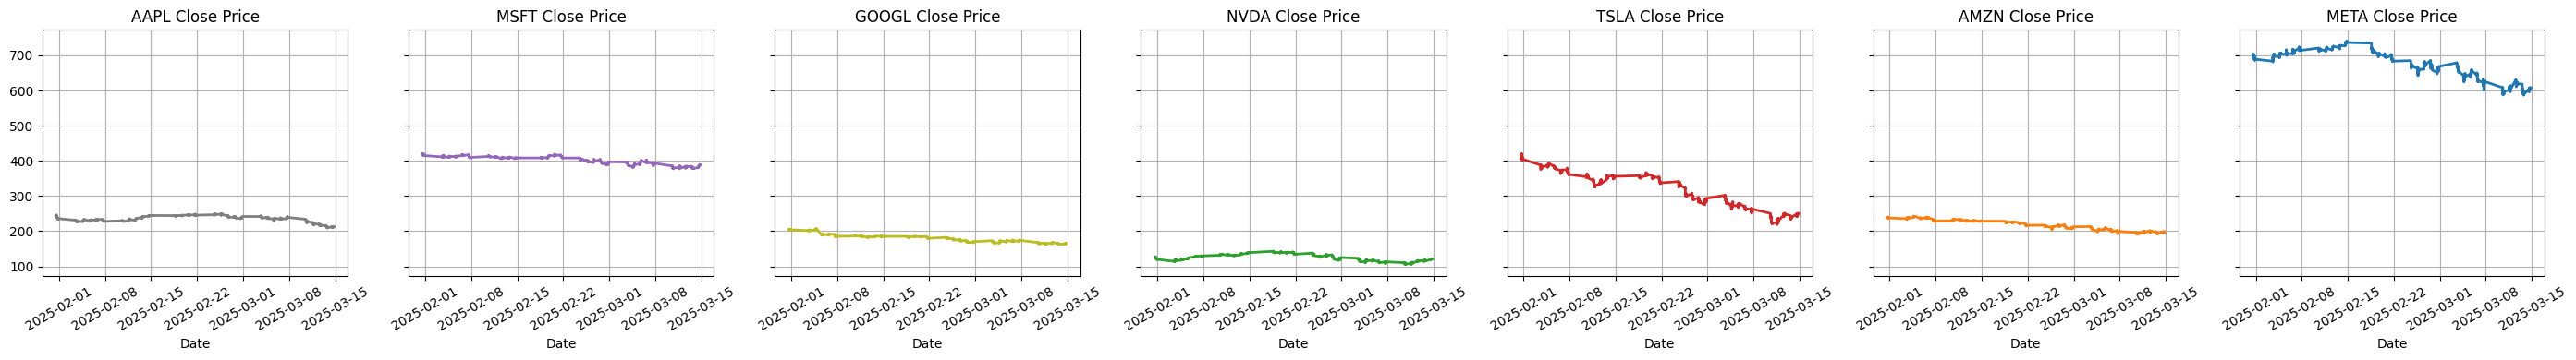

In [60]:
# Close Price Trends Facet (7 columns)
fig, axes = plt.subplots(1, 7, figsize=(28, 4), sharey=True)
for ax, stock, color in zip(axes, stocks, colors):
    df_stock = df[df['Ticker'] == stock]
    ax.plot(df_stock.index, df_stock['Close'], color=color, linewidth=2)
    ax.set_title(f'{stock} Close Price')
    ax.set_xlabel('Date')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
    ax.grid(True)
plt.tight_layout()
plt.show()

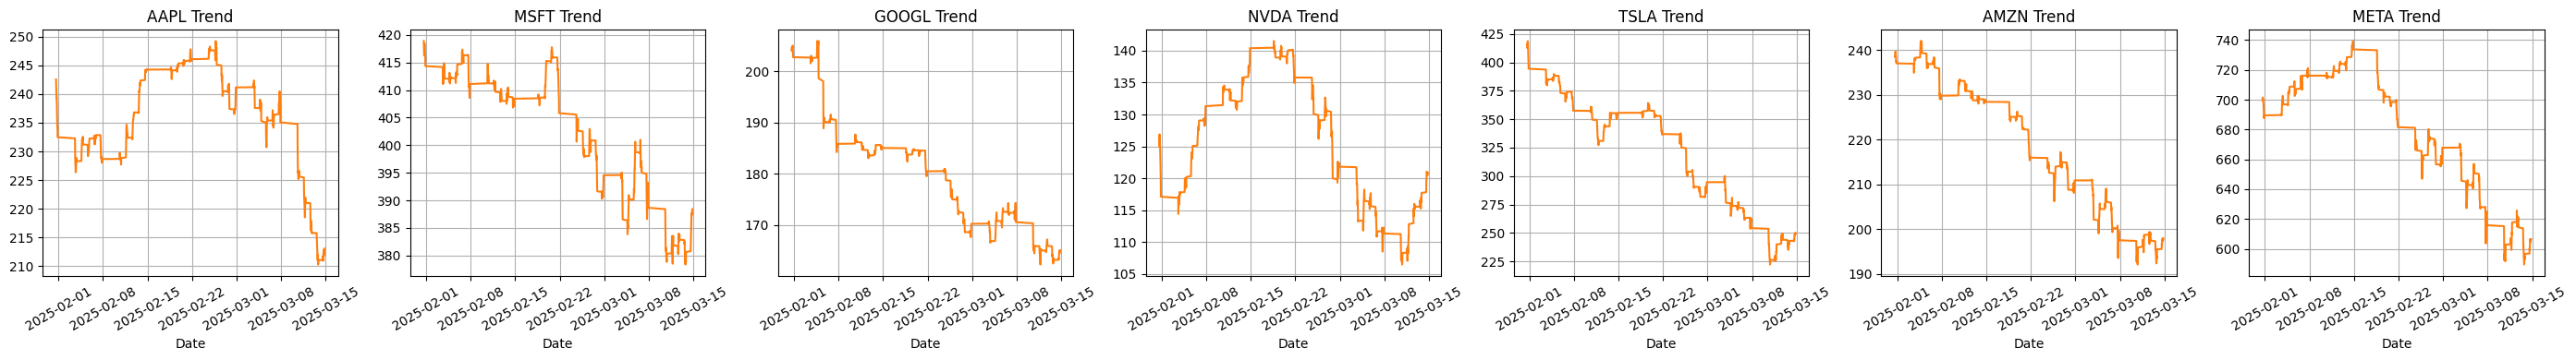

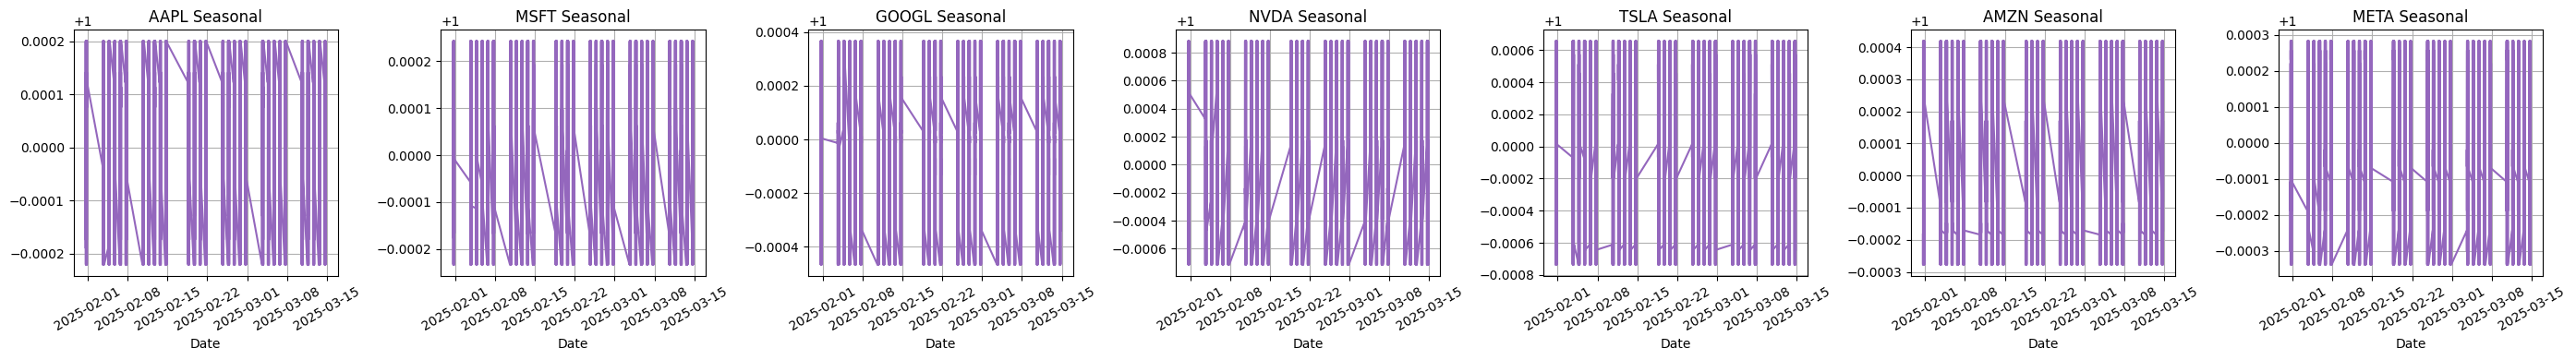

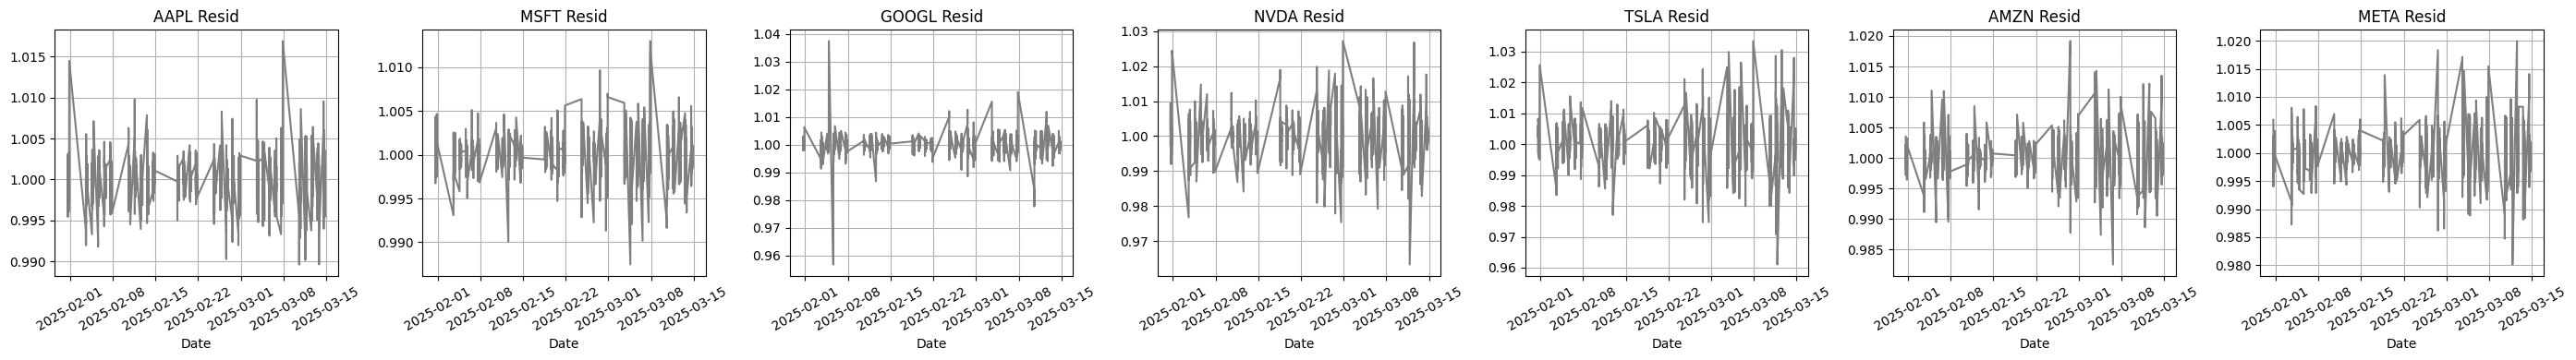

In [61]:
# Seasonal Decomposition Facet (7 columns — one row per component across all stocks)
component_colors = {'trend': 'tab:orange', 'seasonal': 'tab:purple', 'resid': 'tab:gray'}
for comp, comp_color in component_colors.items():
    fig, axes = plt.subplots(1, 7, figsize=(28, 4))
    for ax, stock, color in zip(axes, stocks, colors):
        df_stock = df[df['Ticker'] == stock]
        result = seasonal_decompose(df_stock['Close'], model='multiplicative', period=30)
        comp_series = getattr(result, comp)
        ax.plot(comp_series.index, comp_series, color=comp_color)
        ax.set_title(f'{stock} {comp.capitalize()}')
        ax.set_xlabel('Date')
        for label in ax.get_xticklabels():
            label.set_rotation(30)
        ax.grid(True)
    plt.tight_layout()
    plt.show()

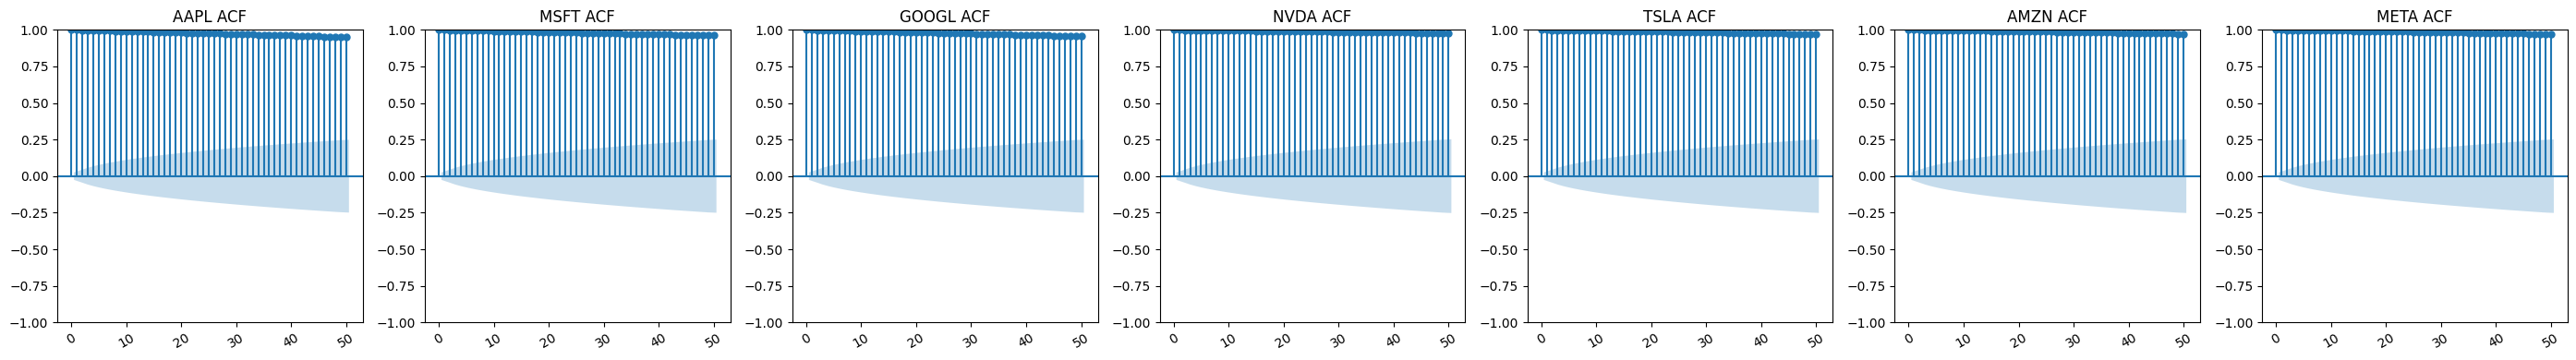

In [62]:
# Standard ACF Facet (7 columns)
fig, axes = plt.subplots(1, 7, figsize=(28, 4))
for ax, stock in zip(axes, stocks):
    df_stock = df[df['Ticker'] == stock]
    plot_acf(df_stock['Close'].dropna(), lags=50, ax=ax)
    ax.set_title(f'{stock} ACF')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
plt.tight_layout()
plt.show()

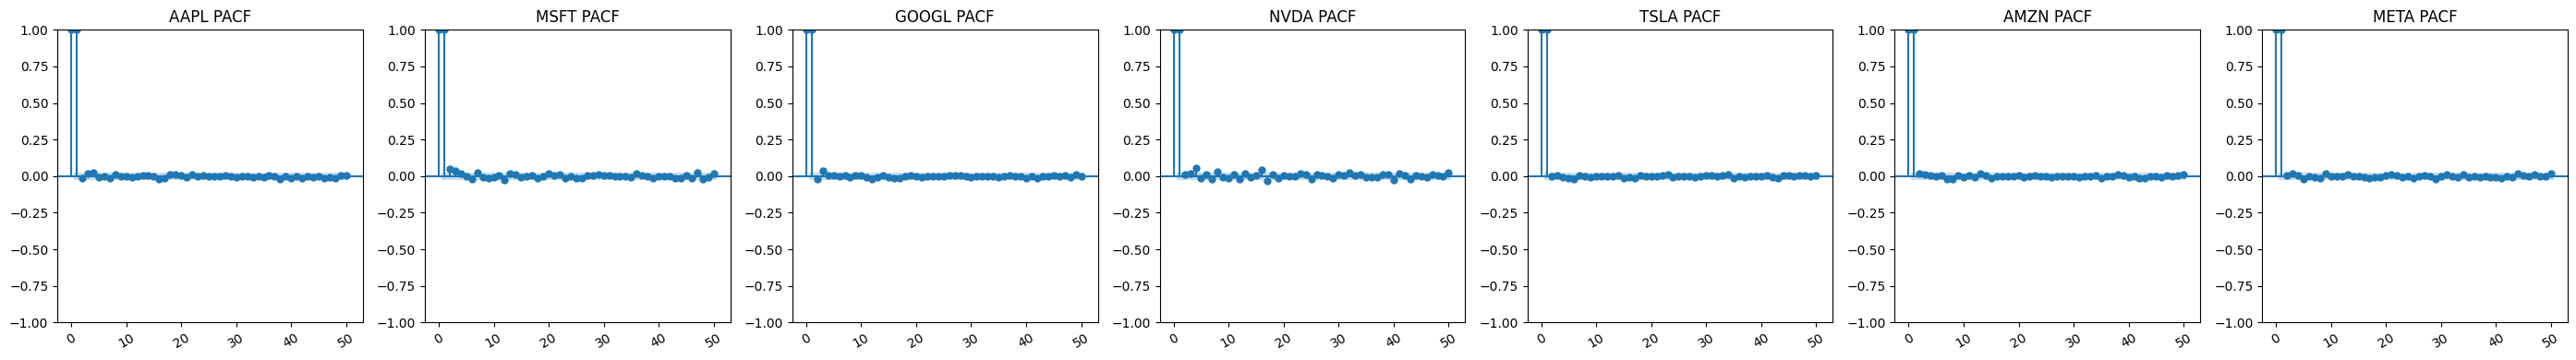

In [63]:
# Standard PACF Facet (7 columns)
fig, axes = plt.subplots(1, 7, figsize=(28, 4))
for ax, stock in zip(axes, stocks):
    df_stock = df[df['Ticker'] == stock]
    plot_pacf(df_stock['Close'].dropna(), lags=50, ax=ax)
    ax.set_title(f'{stock} PACF')
    for label in ax.get_xticklabels():
        label.set_rotation(30)
plt.tight_layout()
plt.show()

In [64]:
# Stationarity Tests
for stock in stocks:
    df_stock = df[df['Ticker'] == stock]
    adf_result = adfuller(df_stock['Close'].dropna())
    print(f'ADF Statistic for {stock}: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}')
    if adf_result[1] < 0.05:
        print(f"{stock} series is likely stationary.")
    else:
        print(f"{stock} series is likely non-stationary.")

ADF Statistic for AAPL: -0.2516, p-value: 0.9321
AAPL series is likely non-stationary.
ADF Statistic for MSFT: -1.4130, p-value: 0.5760
MSFT series is likely non-stationary.
ADF Statistic for GOOGL: -1.7164, p-value: 0.4227
GOOGL series is likely non-stationary.
ADF Statistic for NVDA: -1.1477, p-value: 0.6957
NVDA series is likely non-stationary.
ADF Statistic for TSLA: -1.1037, p-value: 0.7136
TSLA series is likely non-stationary.
ADF Statistic for AMZN: -0.8890, p-value: 0.7916
AMZN series is likely non-stationary.
ADF Statistic for META: -0.4163, p-value: 0.9073
META series is likely non-stationary.


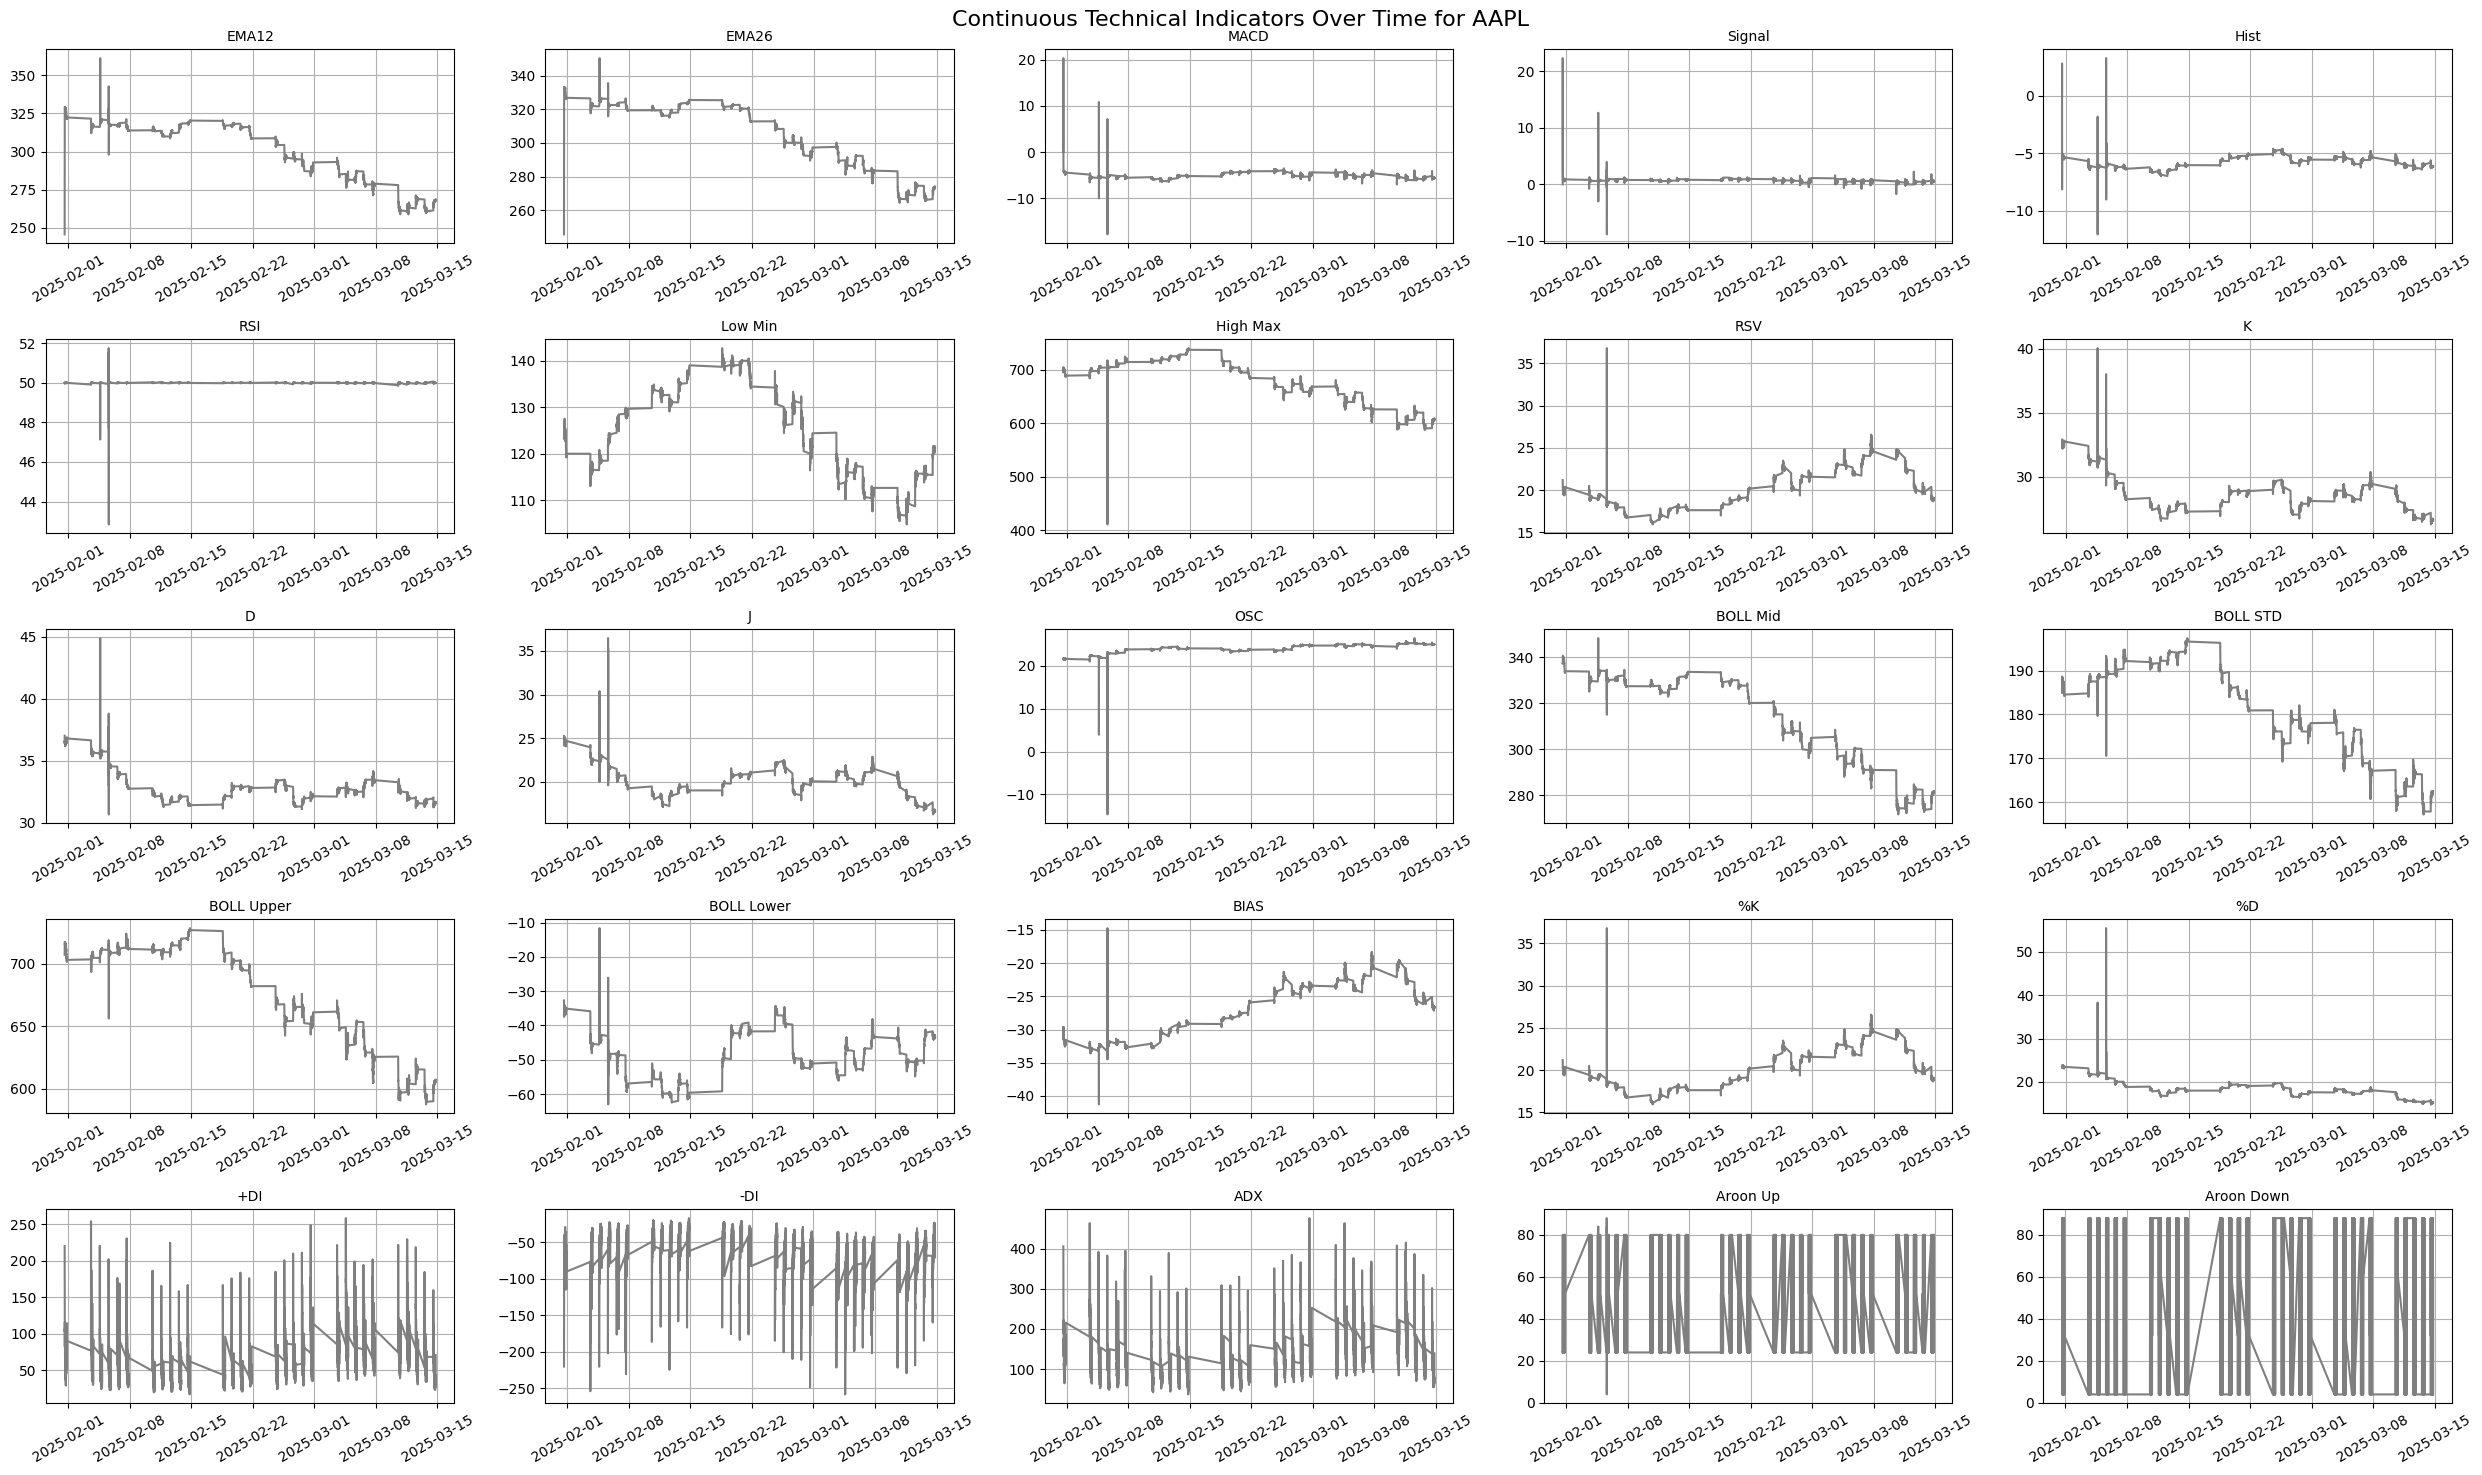

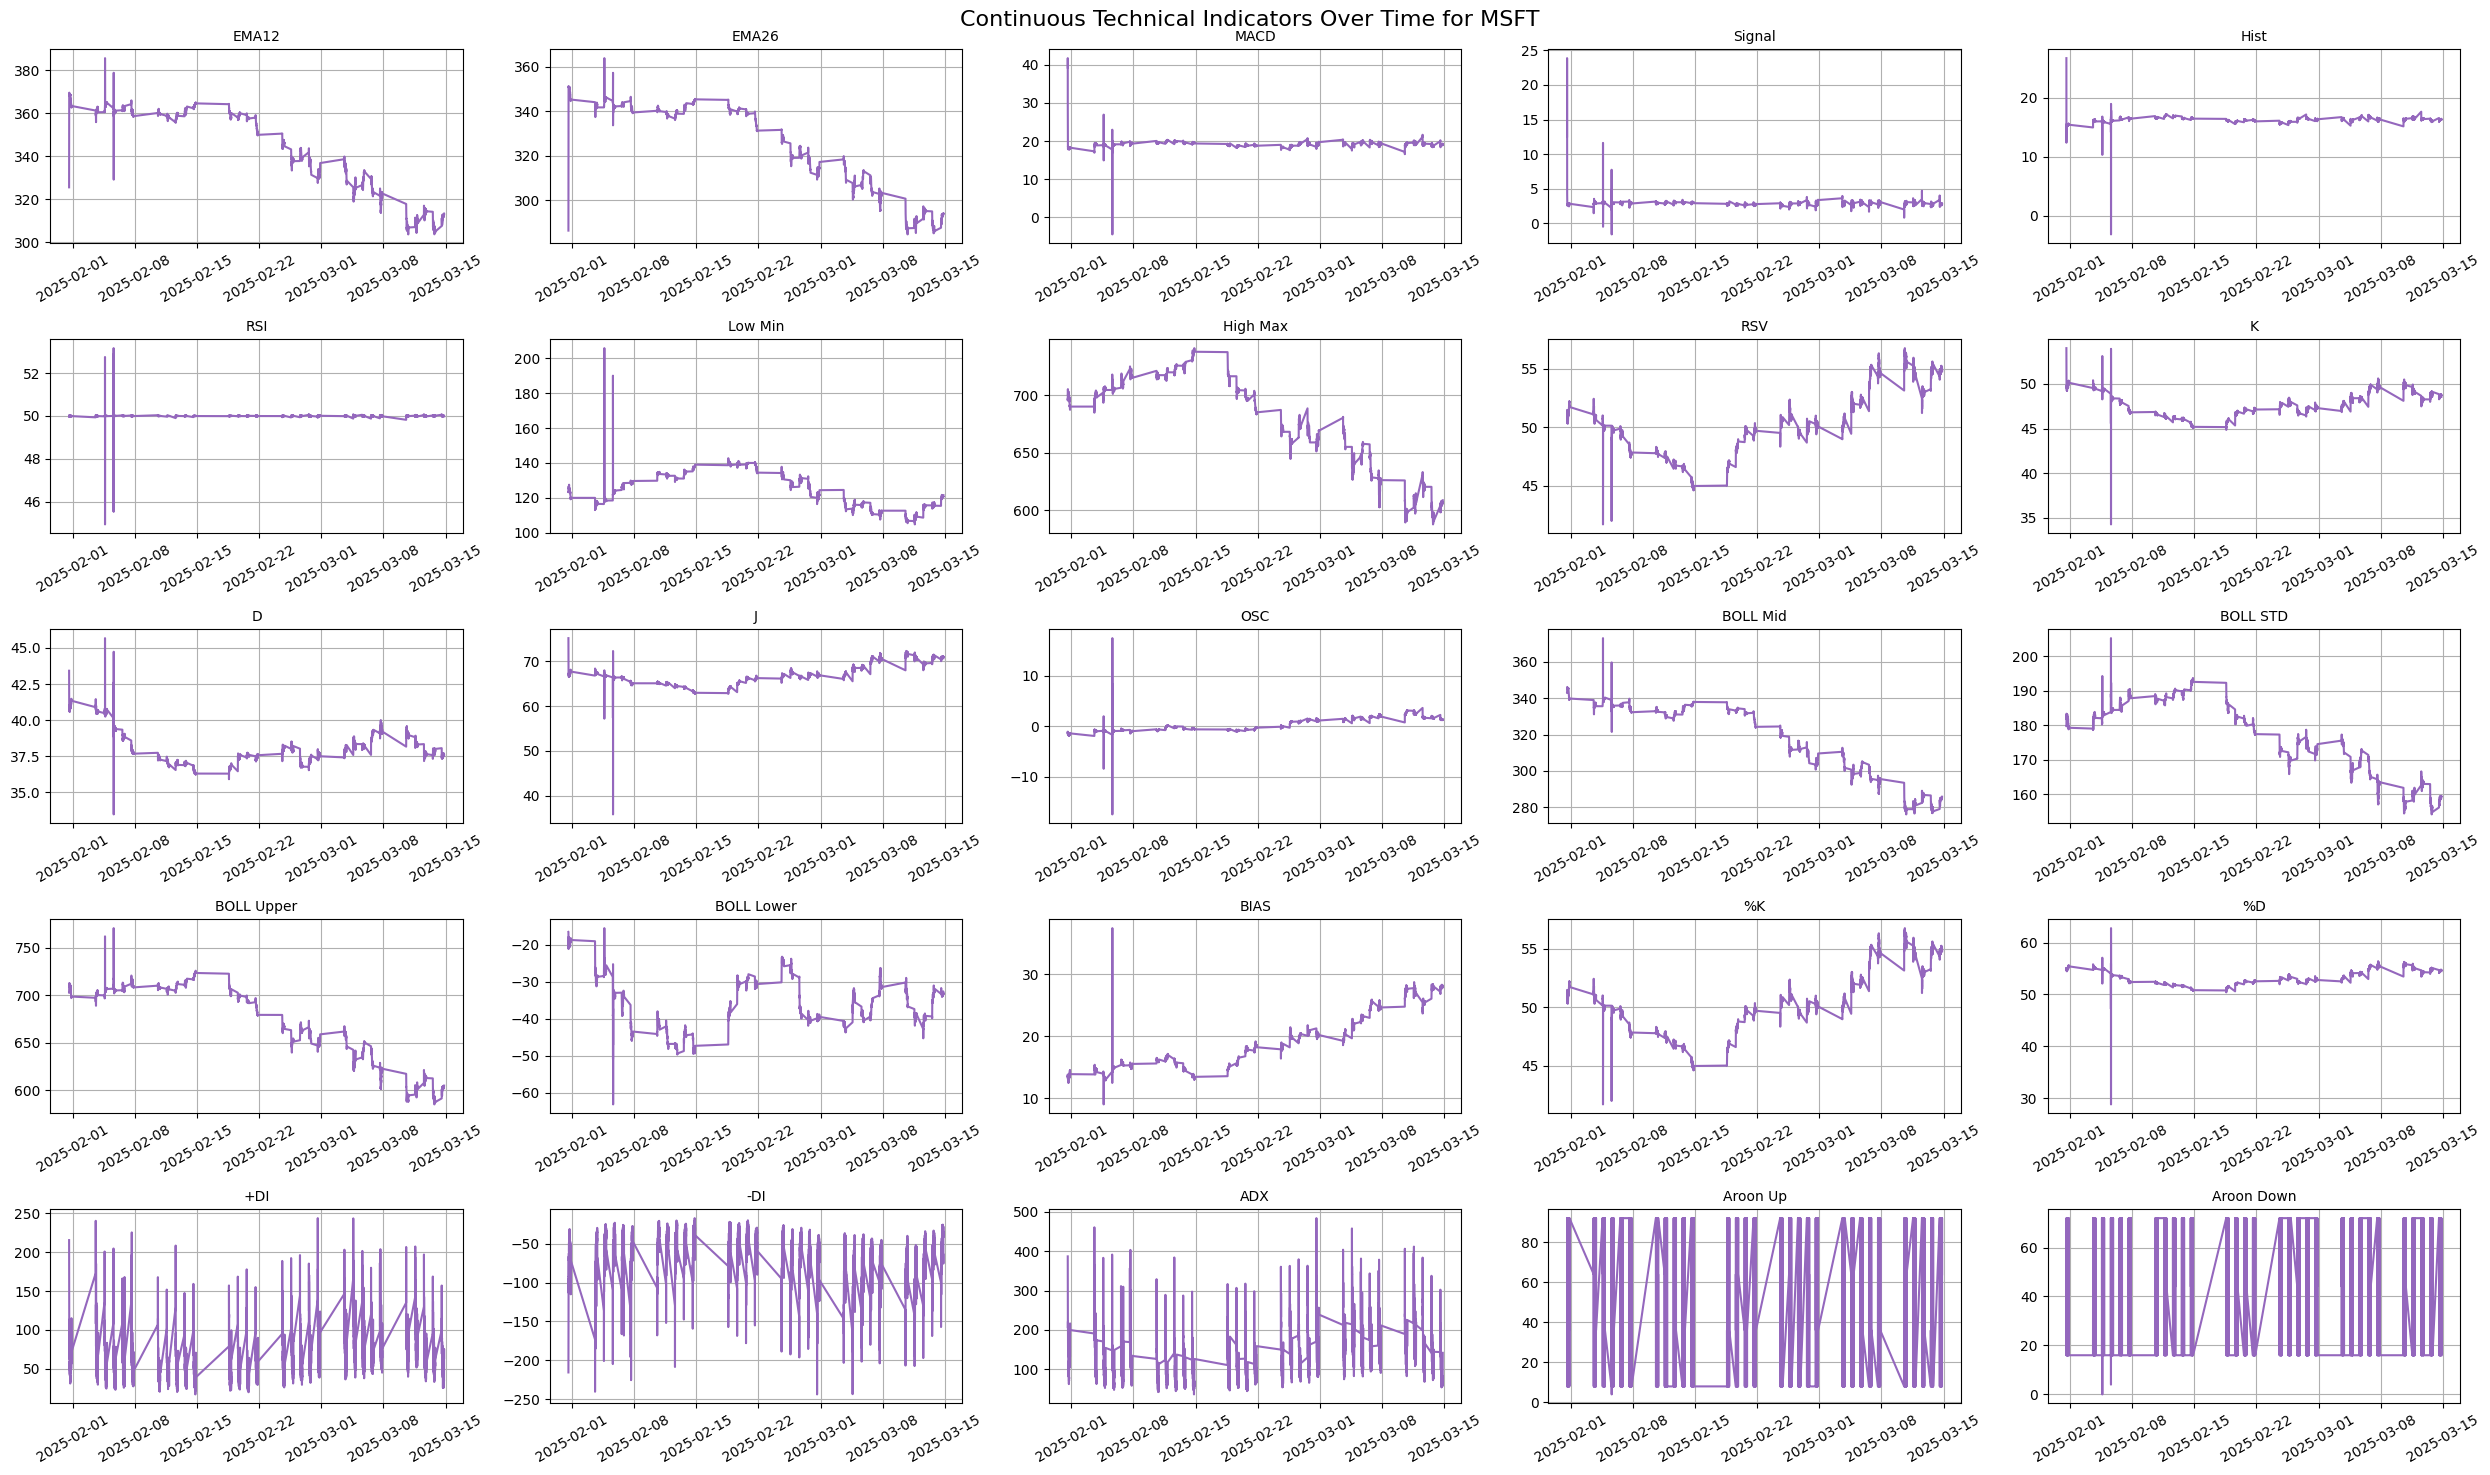

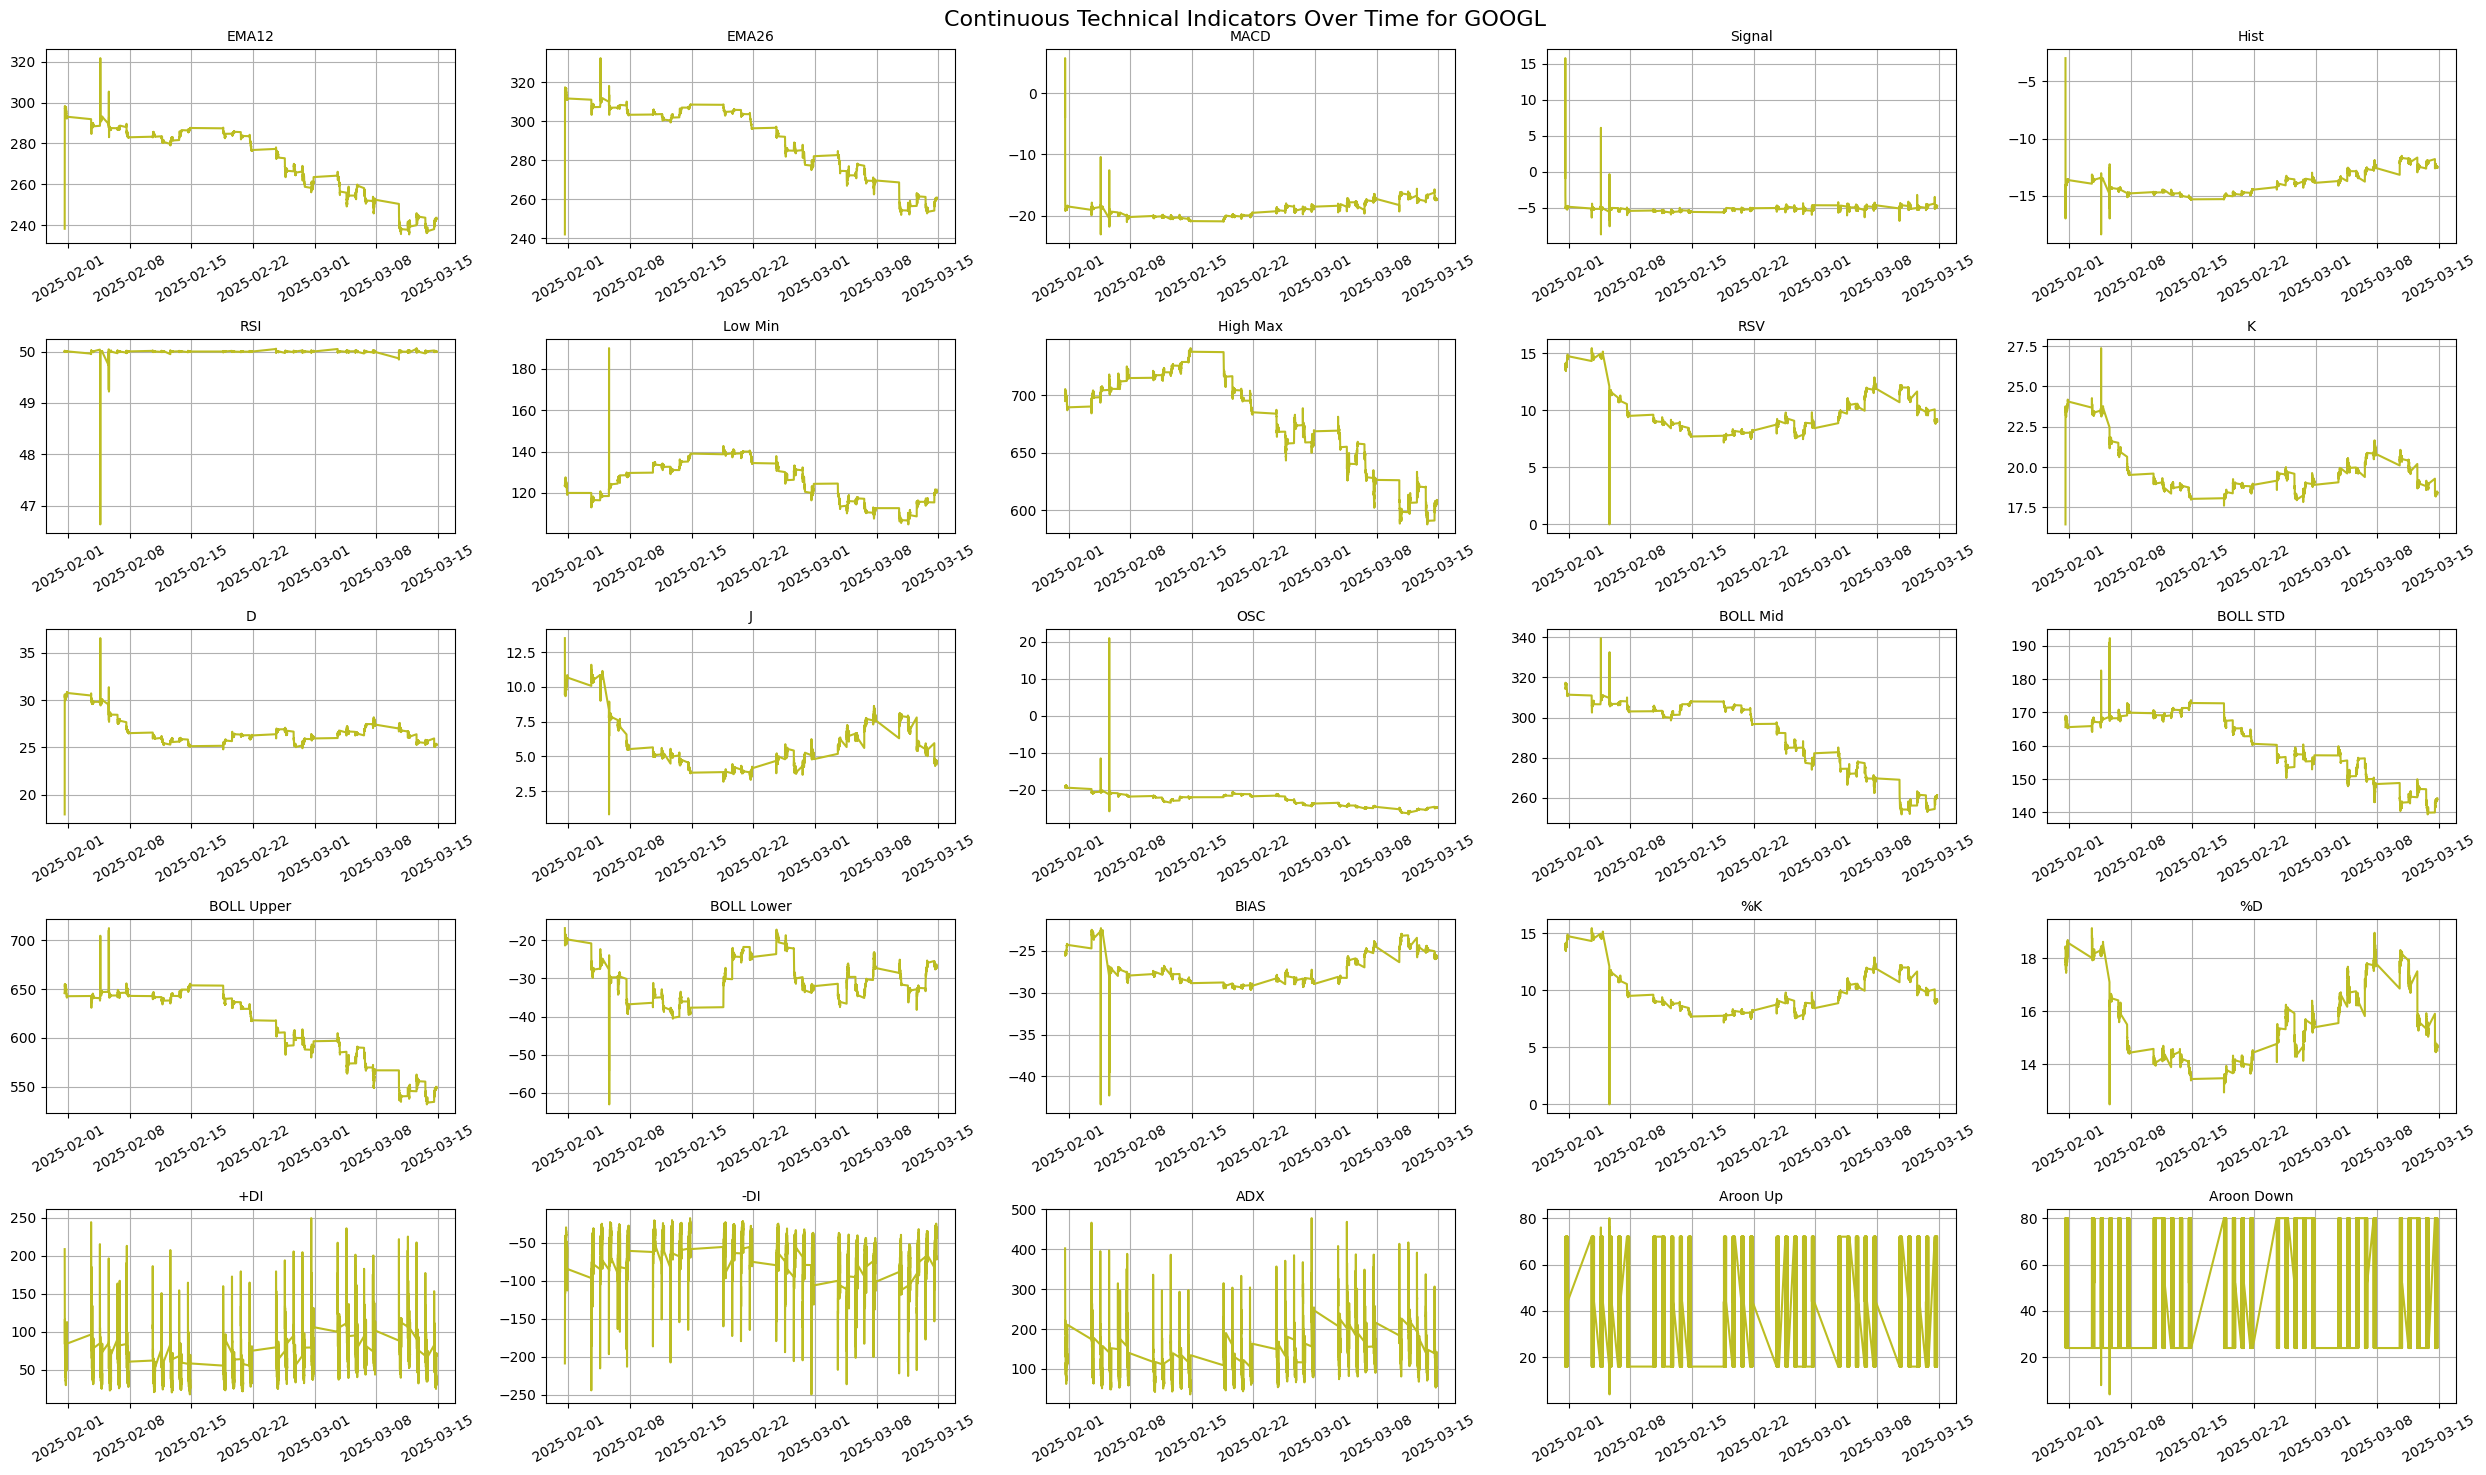

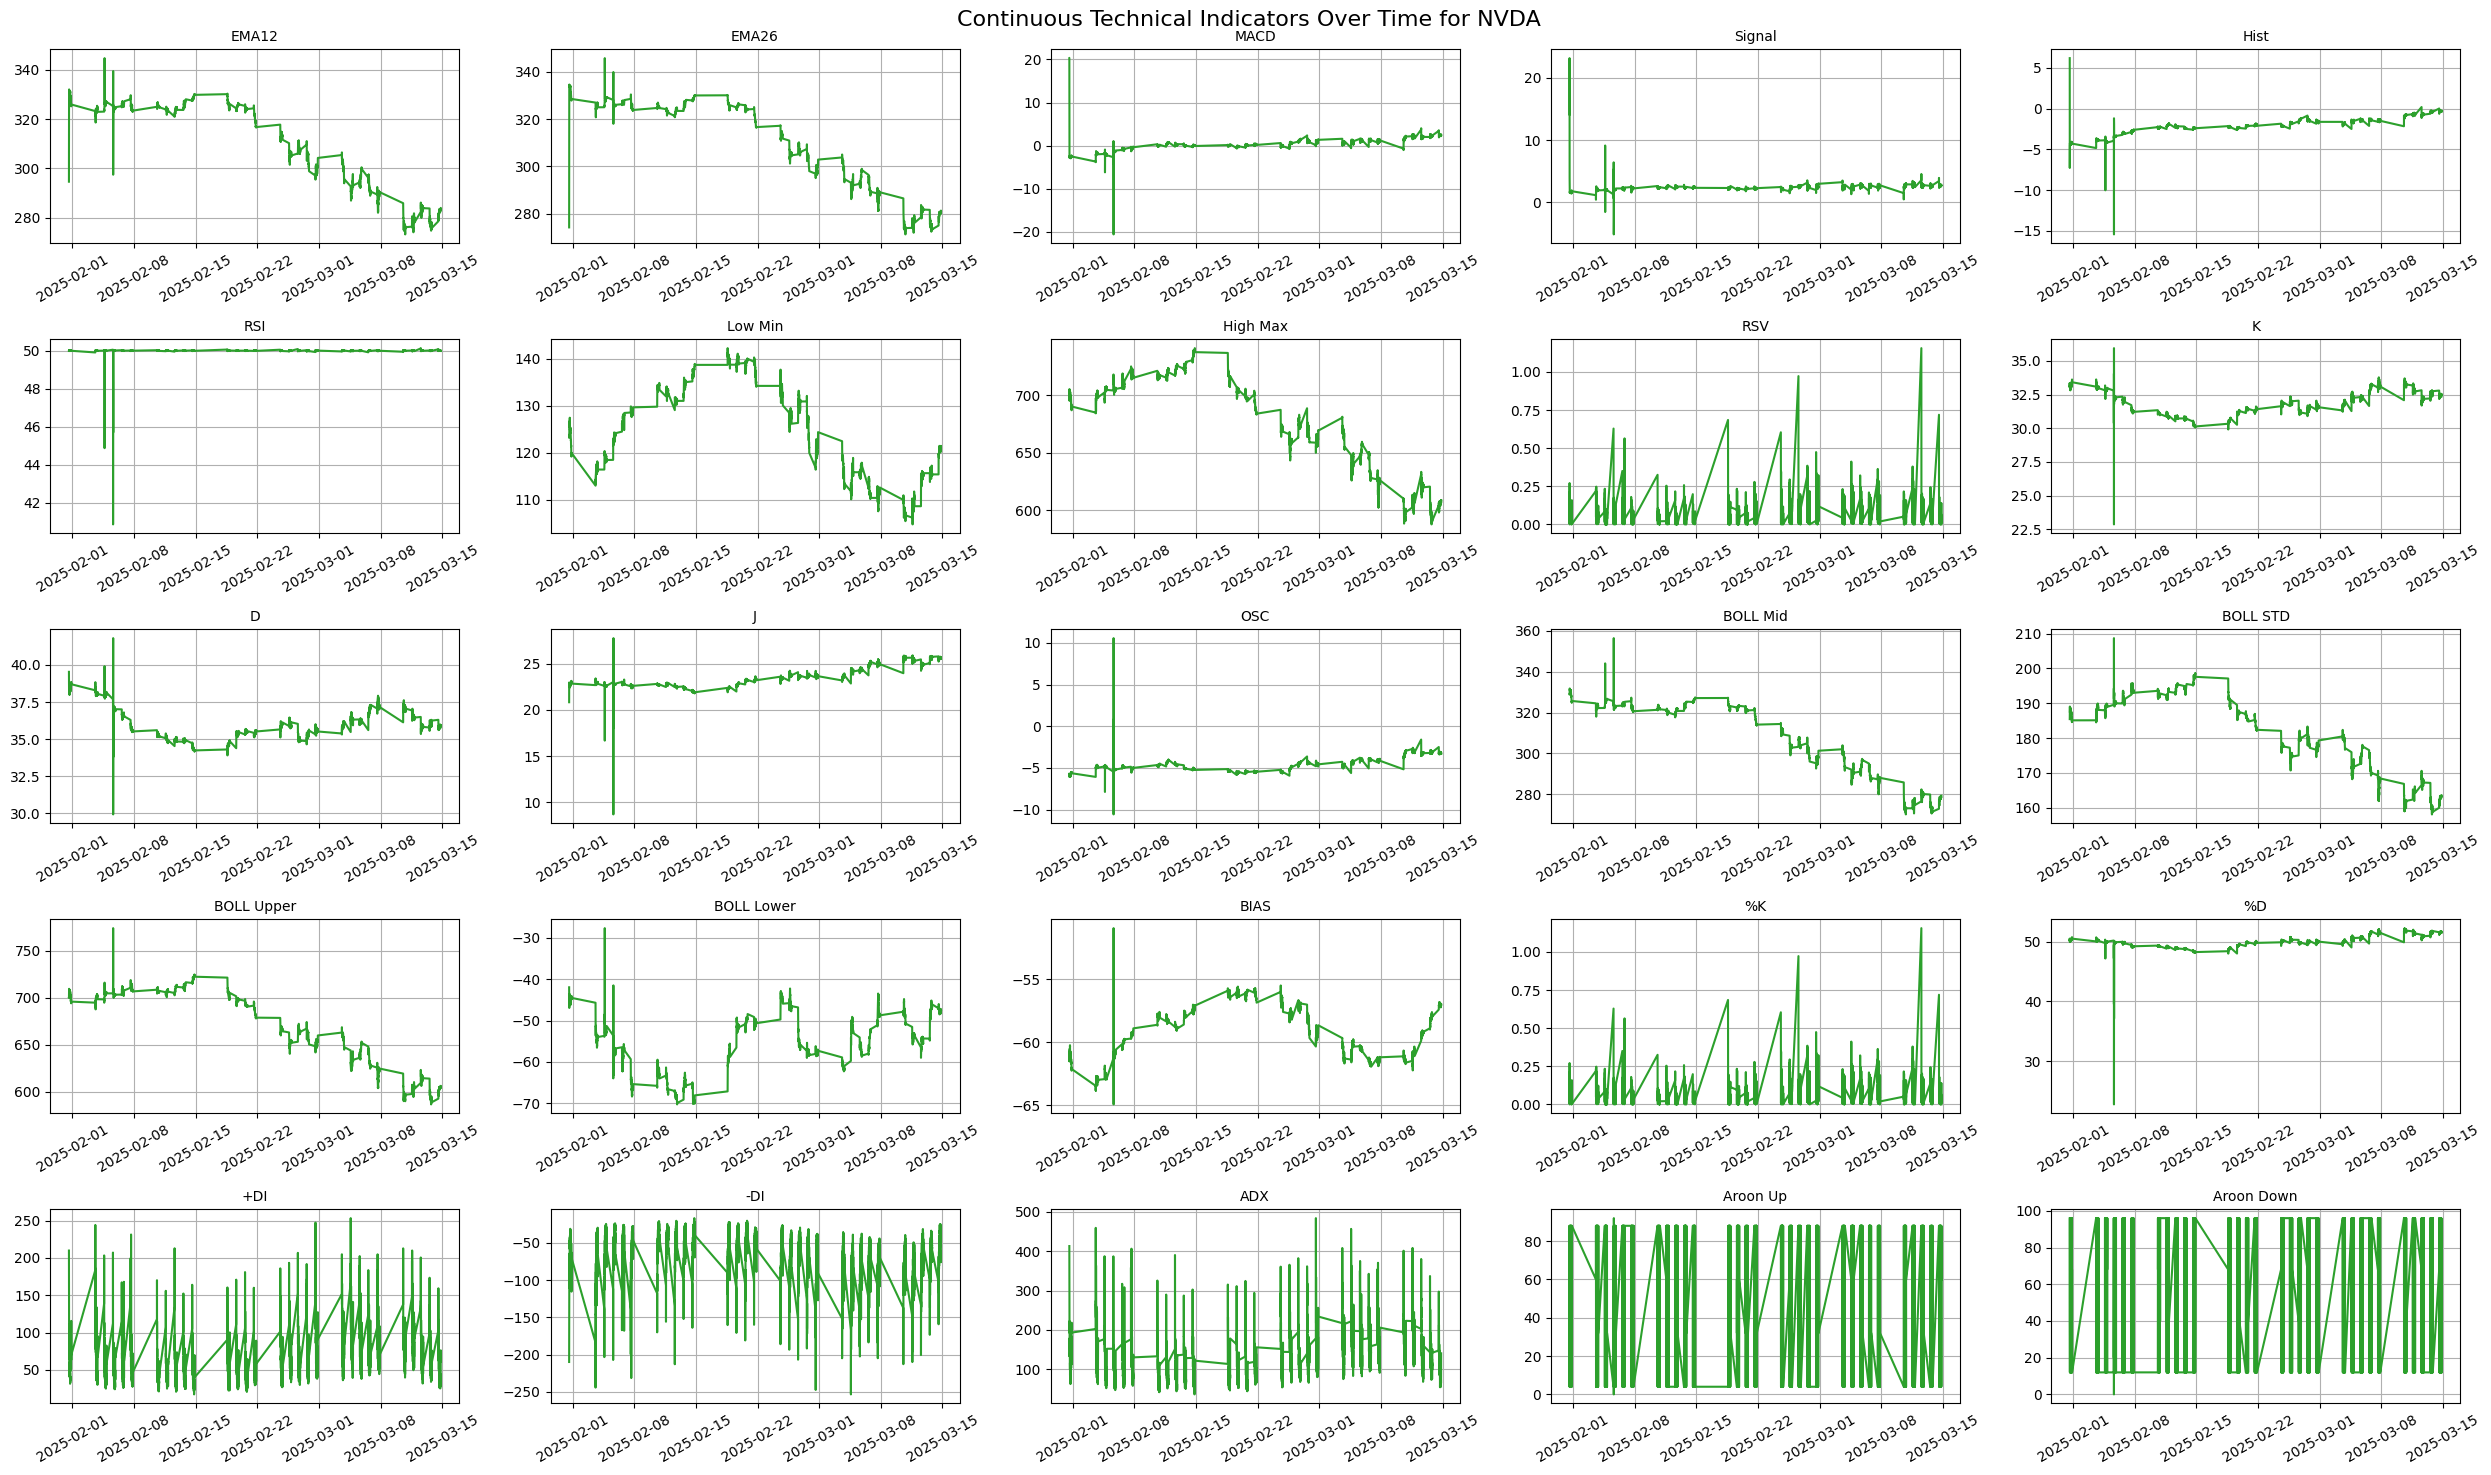

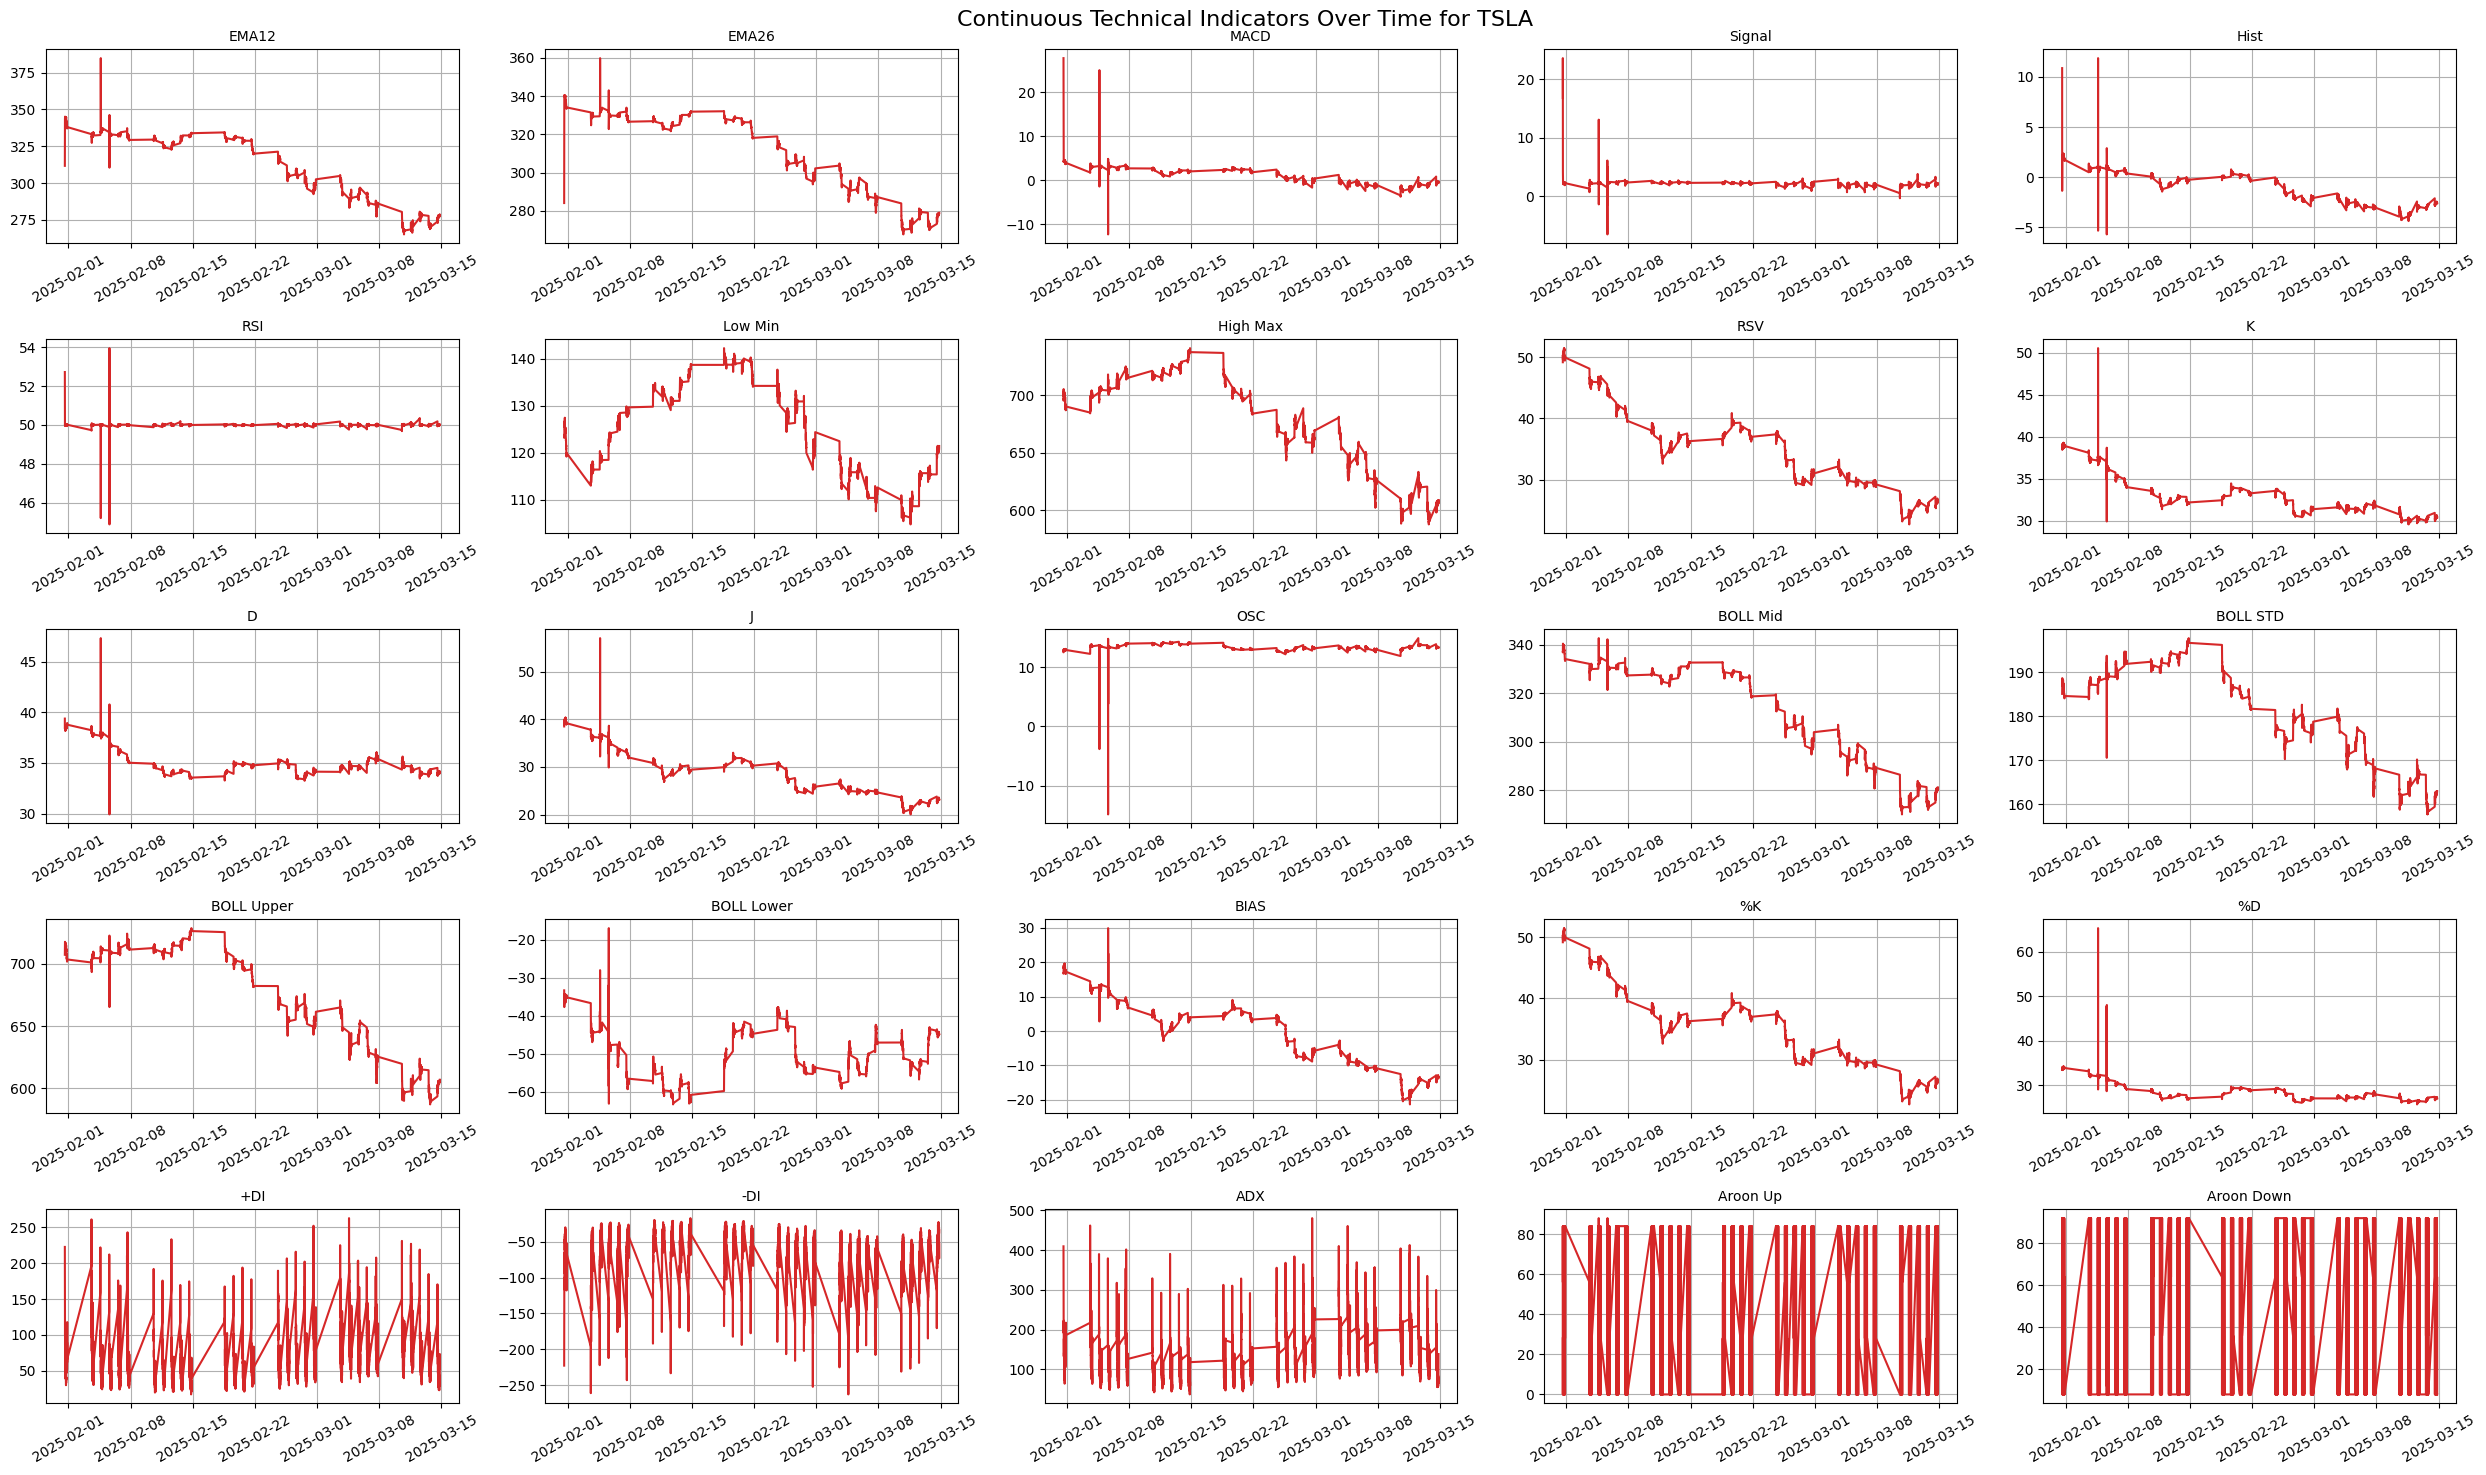

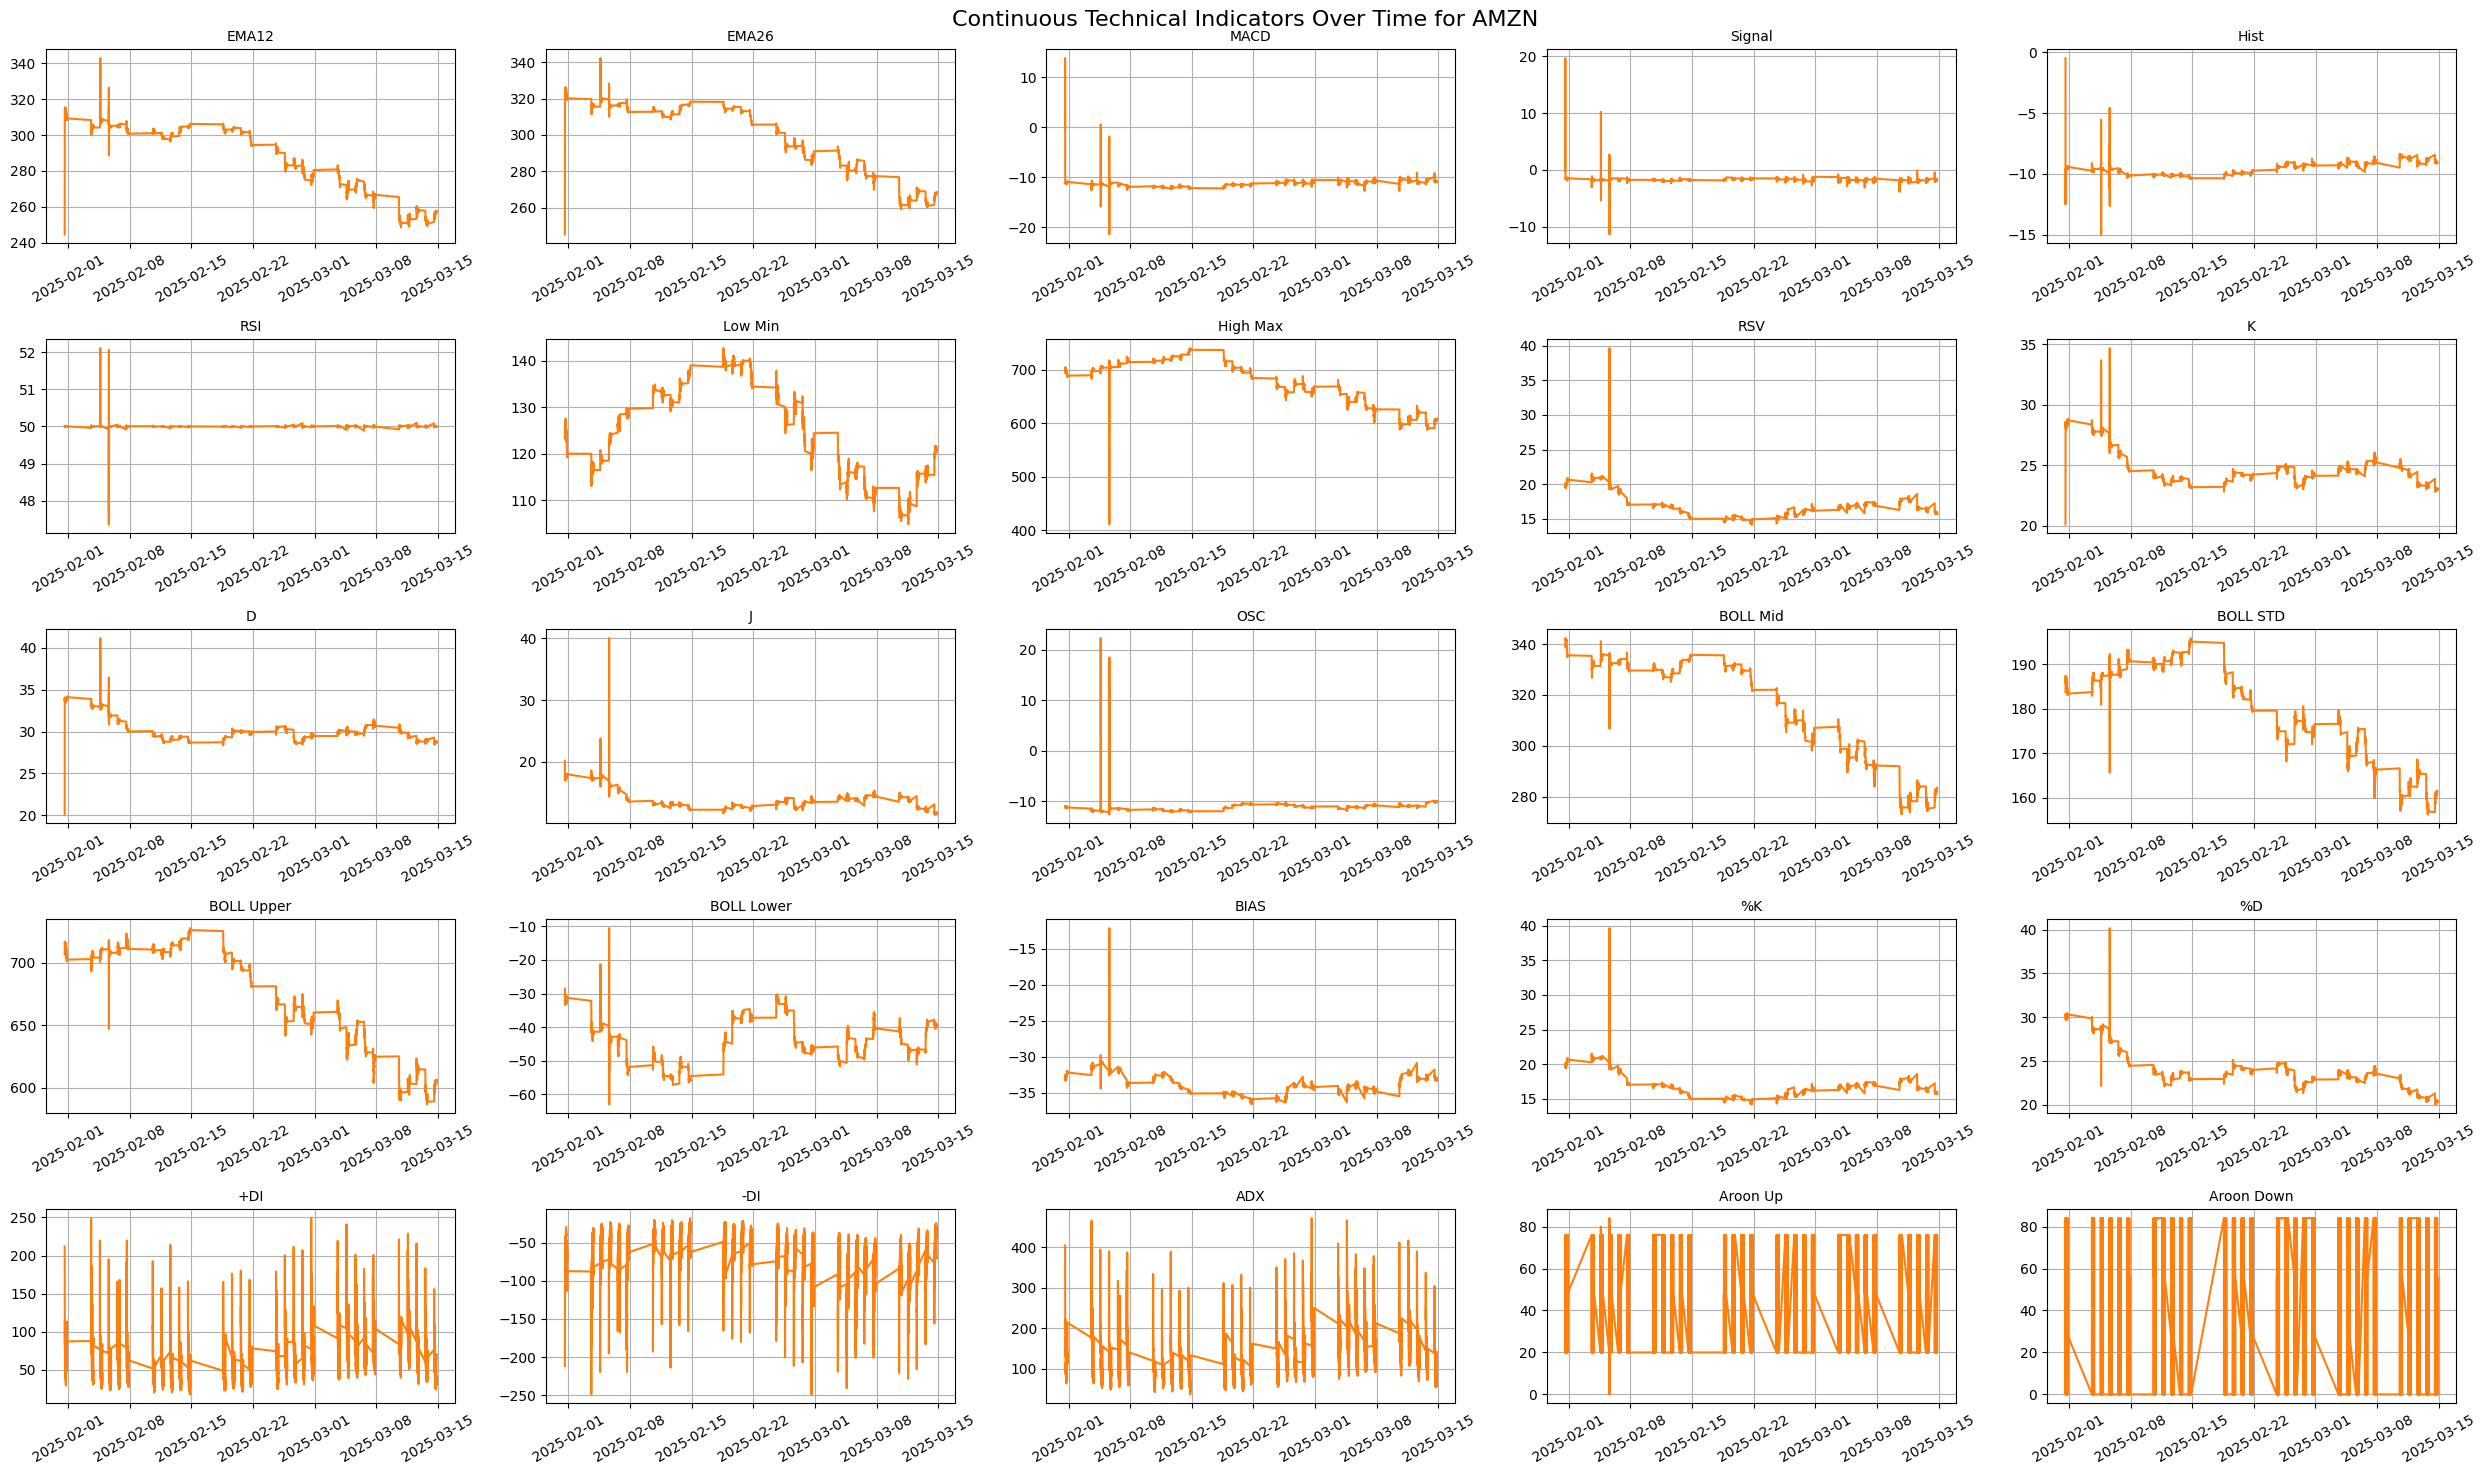

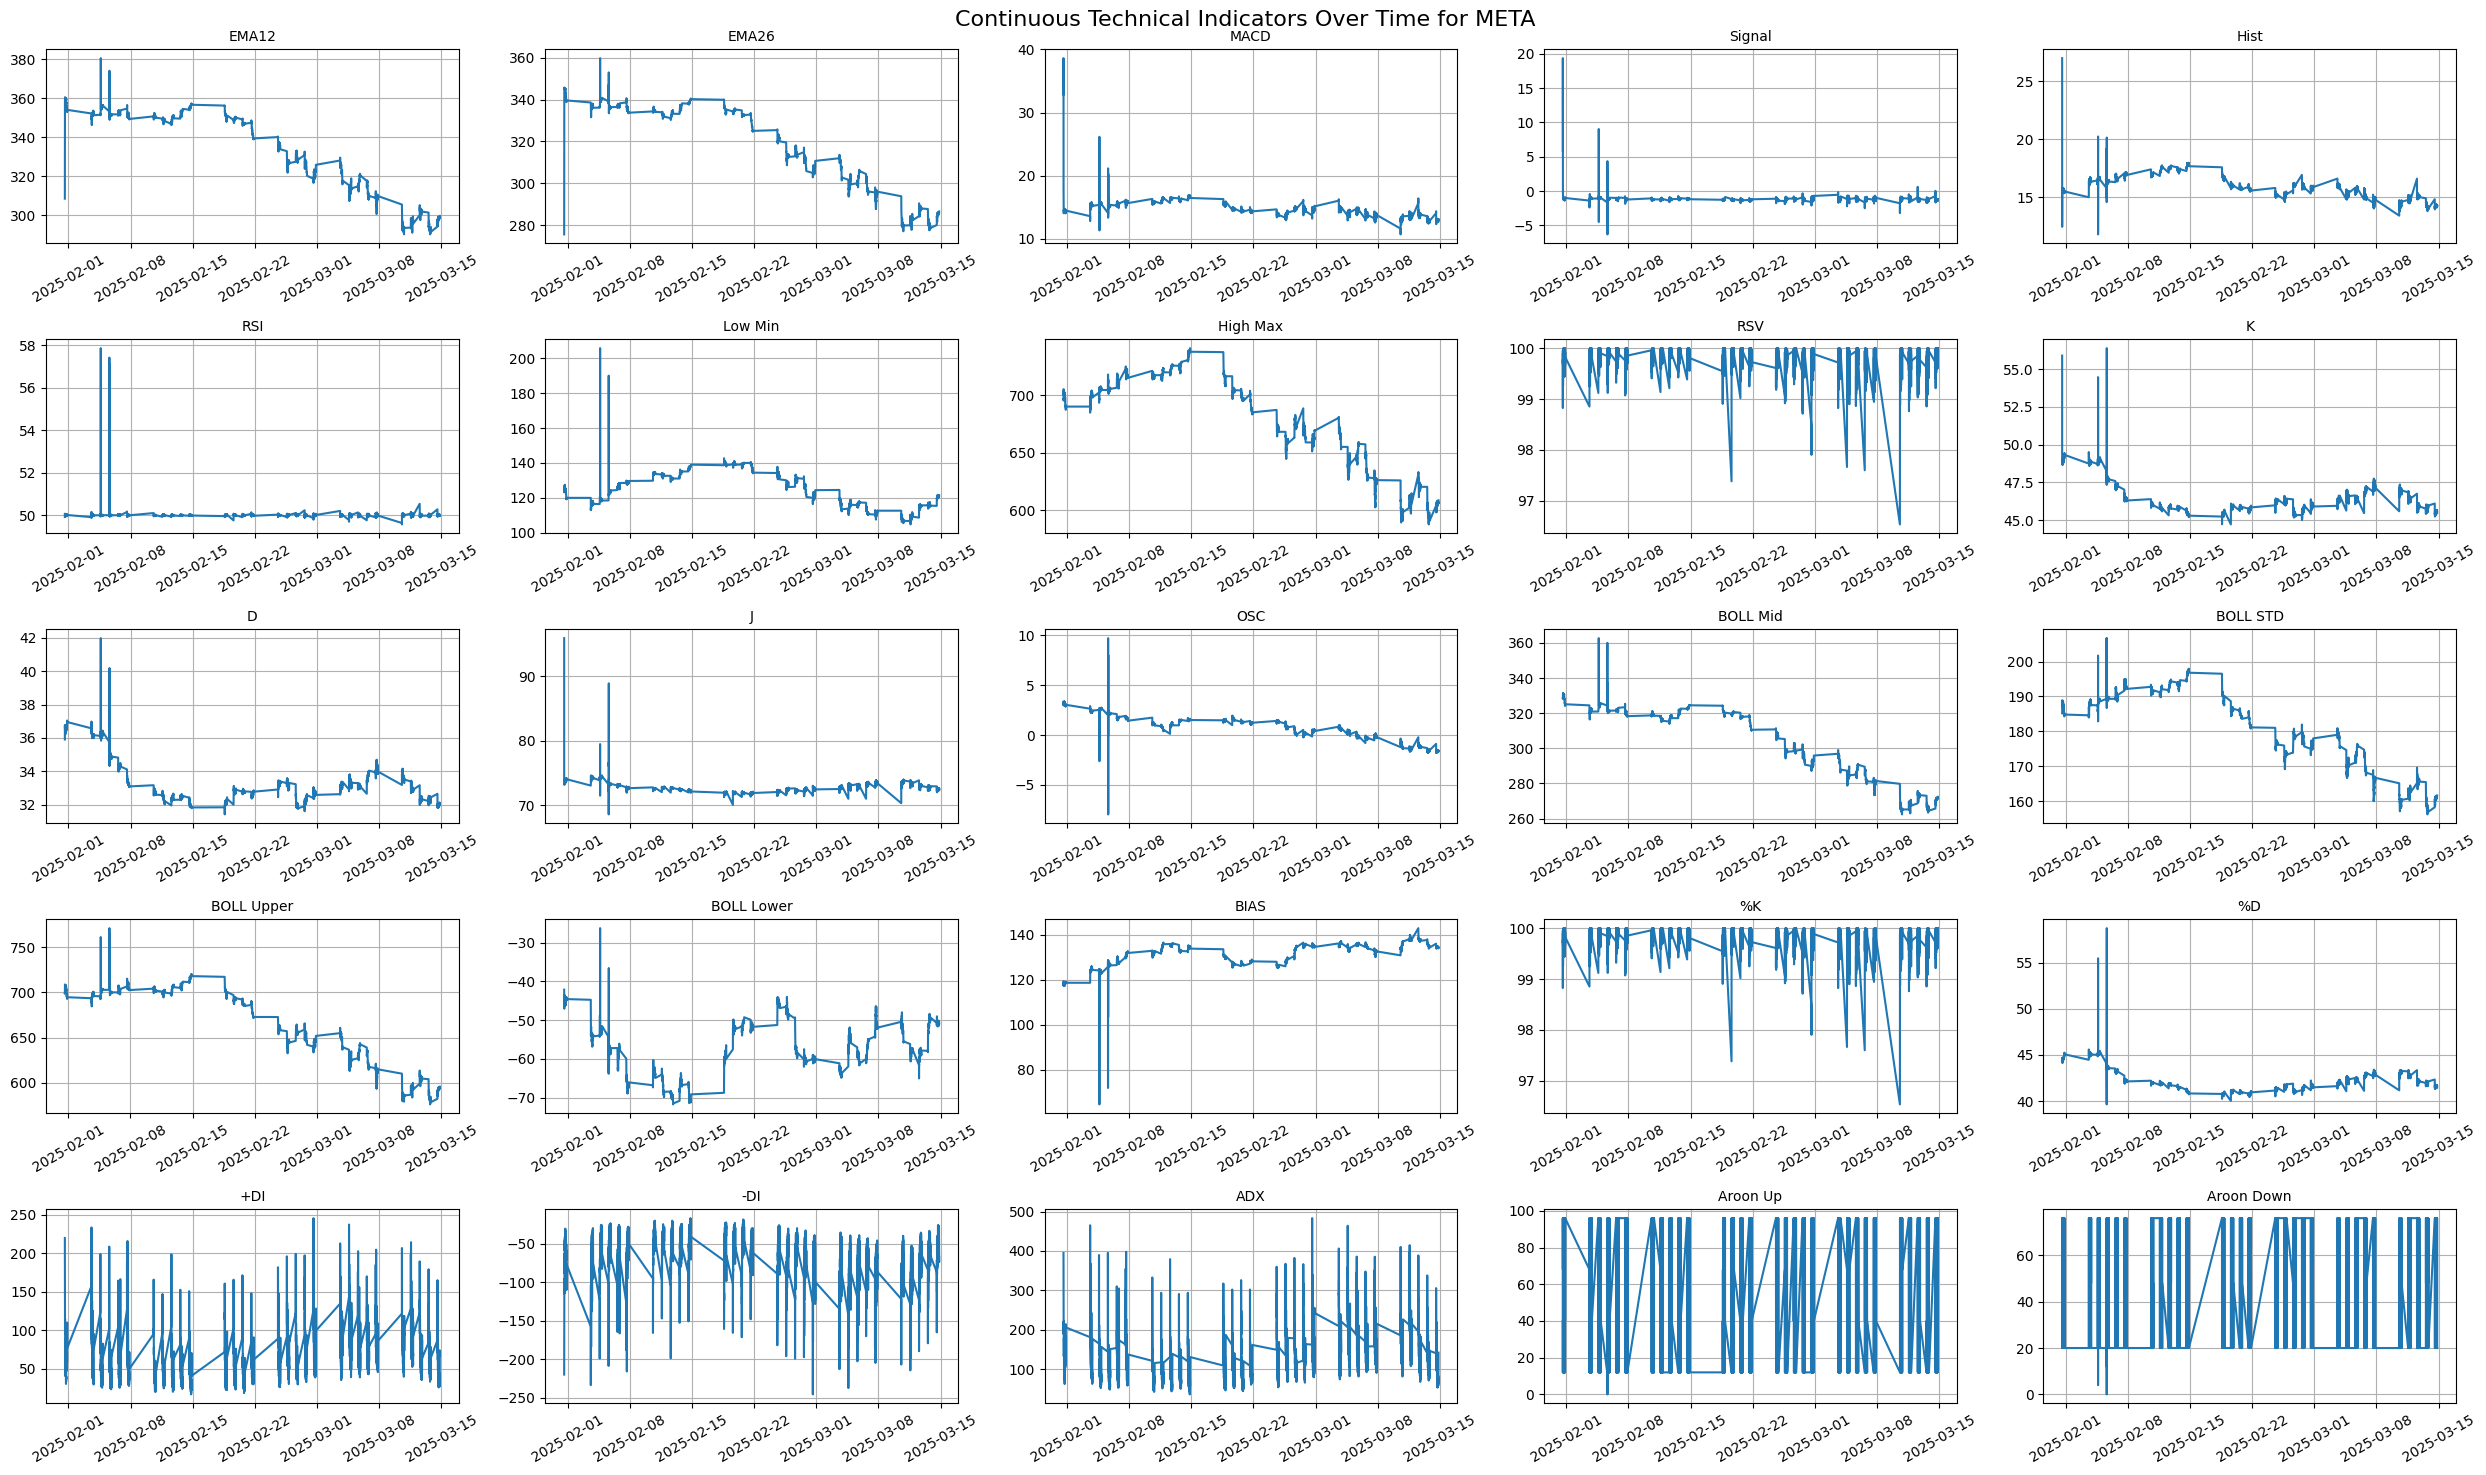

In [65]:
# Visualization of continuous technical indicators (excluding Buy/Sell binary columns) in a 5-column facet for each ticker
technical_columns = [col for col in df.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker'] and 'Buy' not in col and 'Sell' not in col]
for stock, color in zip(stocks, colors):
    df_stock = df[df['Ticker'] == stock]
    n_cols = 5
    n_rows = (len(technical_columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, n_rows * 3))
    axes = axes.flatten()

    for i, col in enumerate(technical_columns):
        axes[i].plot(df_stock.index, df_stock[col], color=color)
        axes[i].set_title(col.replace('_', ' '), fontsize=10)
        axes[i].tick_params(axis='x', rotation=30)
        axes[i].grid(True)

    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Continuous Technical Indicators Over Time for {stock}', fontsize=16)
    plt.tight_layout()
    plt.show()


In [66]:
# Add return target early for volatility plot
df['Return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
df.dropna(subset=['Return'], inplace=True)

# Ensure Datetime is a column
df.reset_index(inplace=True)

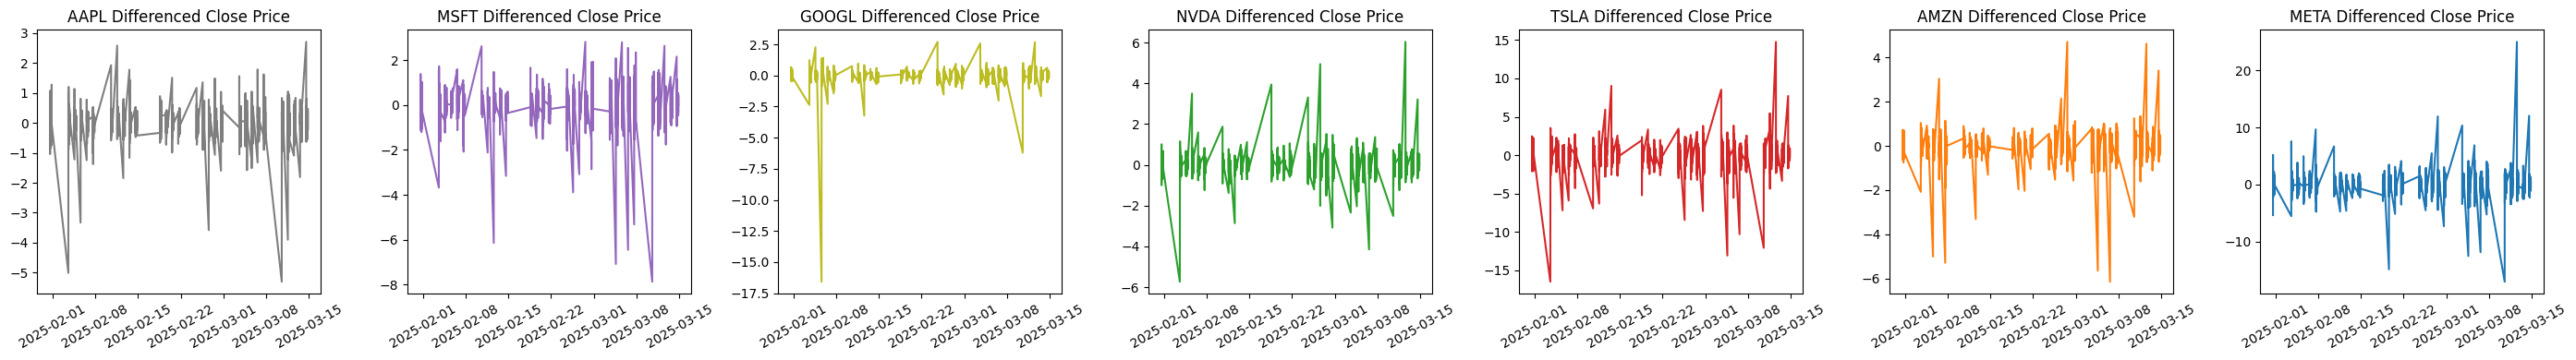

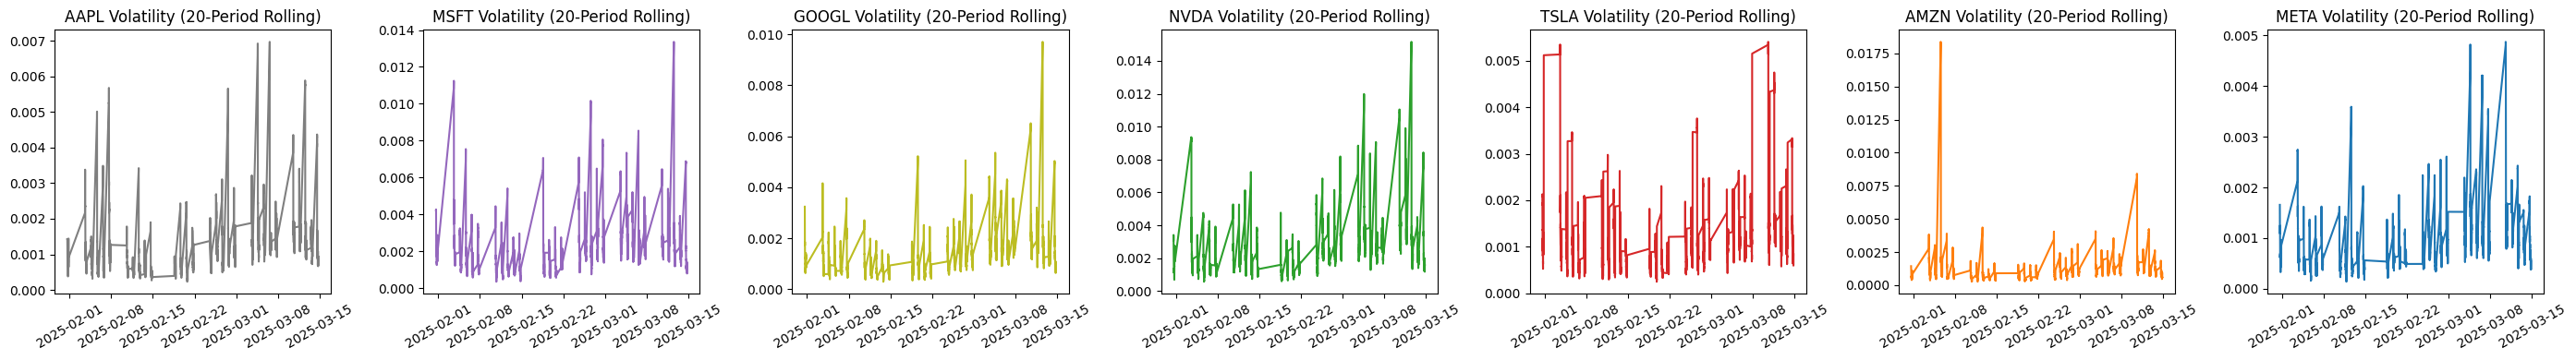

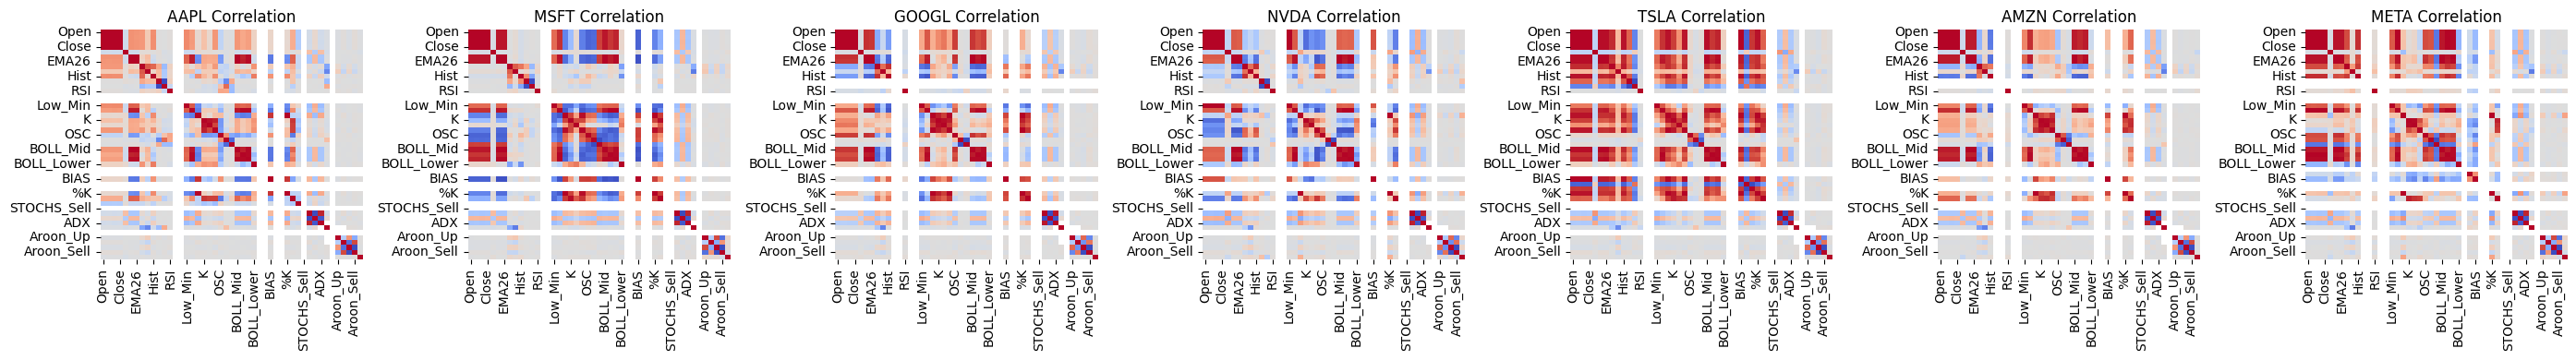

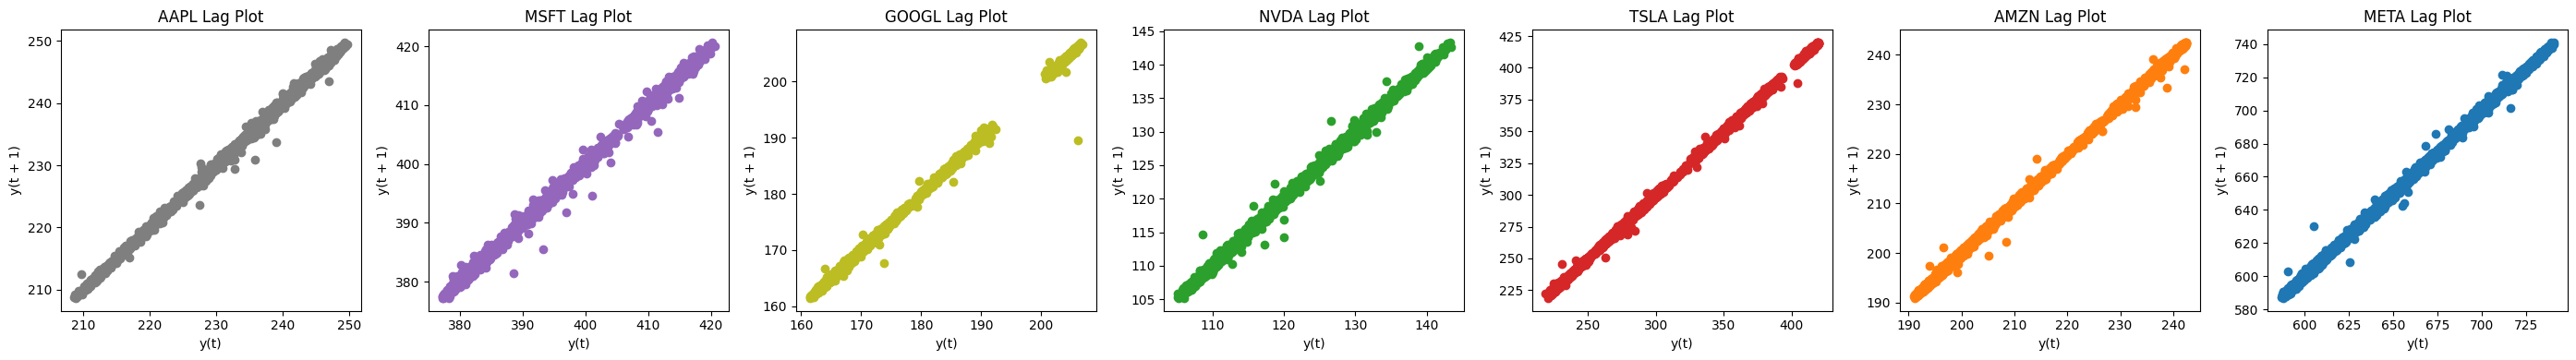

In [67]:
# Faceted plots for differenced close price, volatility, and rolling correlation
for metric_name, plot_func in [
    ("Differenced Close Price", lambda stock_df, ax, color: ax.plot(stock_df['Datetime'], stock_df['Close'].diff(), color=color)),
    ("Volatility (20-Period Rolling)", lambda stock_df, ax, color: ax.plot(stock_df['Datetime'], stock_df['Return'].rolling(window=20).std(), color=color)),
]:
    fig, axes = plt.subplots(1, 7, figsize=(28, 4))
    for ax, stock, color in zip(axes, stocks, colors):
        df_stock = df[df['Ticker'] == stock].copy()
        plot_func(df_stock, ax, color)
        ax.set_title(f'{stock} {metric_name}')
        ax.tick_params(axis='x', rotation=30)
    plt.tight_layout()
    plt.show()

# Faceted correlation heatmaps (7 columns)
fig, axes = plt.subplots(1, 7, figsize=(28, 4))
for ax, stock in zip(axes, stocks):
    df_stock = df[df['Ticker'] == stock]
    features_corr = df_stock.drop(columns=[col for col in ['Datetime', 'Ticker'] if col in df_stock.columns]).corr()
    sns.heatmap(features_corr, cmap='coolwarm', annot=False, cbar=False, ax=ax)
    ax.set_title(f'{stock} Correlation')
plt.tight_layout()
plt.show()

# Facet lag plots
fig, axes = plt.subplots(1, 7, figsize=(28, 4))
for ax, stock, color in zip(axes, stocks, colors):
    df_stock = df[df['Ticker'] == stock].copy()
    lag_plot(df_stock['Close'].dropna(), ax=ax, c=color)
    ax.set_title(f'{stock} Lag Plot')
plt.tight_layout()
plt.show()

In [68]:
# Add return target for modeling and volatility plots
df['Return'] = df.groupby('Ticker')['Close'].pct_change().shift(-1)
df.dropna(subset=['Return'], inplace=True)

# Ensure correct datetime and indexing
df = df.sort_values(['Ticker', 'Datetime']).reset_index(drop=True)

# Prepare sequences for LSTM training
def prepare_sequences(df, feature_cols, sequence_length=20):
    feature_scaler = RobustScaler()
    return_scaler = RobustScaler()

    X_scaled = feature_scaler.fit_transform(df[feature_cols])
    y_scaled = return_scaler.fit_transform(df[['Return']])

    X_sequences, y_sequences, dates, close_prices = [], [], df['Datetime'].values[sequence_length:], df['Close'].values[sequence_length:]

    for i in range(len(X_scaled) - sequence_length):
        X_sequences.append(X_scaled[i:i+sequence_length])
        y_sequences.append(y_scaled[i+sequence_length])

    return np.array(X_sequences), np.array(y_sequences), dates, close_prices, return_scaler

# Improved LSTM model structure
def build_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),

        Bidirectional(LSTM(64, return_sequences=True)),
        BatchNormalization(),
        Dropout(0.3),

        LSTM(32, return_sequences=False),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(1, activation='tanh')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
    return model

# Train and evaluate model
def train_and_evaluate(df, feature_cols, ticker):
    df_ticker = df[df['Ticker'] == ticker].reset_index(drop=True)
    X, y, dates, close_prices, return_scaler = prepare_sequences(df_ticker, feature_cols)

    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    dates_test, close_prices_test = dates[split_idx:], close_prices[split_idx:]

    model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]

    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

    y_pred_scaled = model.predict(X_test)
    y_pred = return_scaler.inverse_transform(y_pred_scaled)
    y_test_actual = return_scaler.inverse_transform(y_test.reshape(-1, 1))

    positions = np.where(y_pred.flatten() > 0, 1, -1)
    strategy_returns = (1 + (y_test_actual.flatten() * positions)).cumprod()
    positions = np.where(y_pred.flatten() > 0, "LONG", "SHORT")

    trades = pd.DataFrame({
        'Date': dates_test,
        'Close_Price': close_prices_test,
        'Actual_Return': y_test_actual.flatten(),
        'Predicted_Return': y_pred.flatten(),
        'Position': positions,
        'Cumulative_Return': strategy_returns,
        'Ticker': ticker
    })

    return trades

feature_cols = ['Close', 'MACD_Buy', 'MACD_Sell', 'RSI_Buy', 'RSI_Sell', 'STOCHS_Buy', 'STOCHS_Sell',
                'ADX_Buy', 'ADX_Sell', 'Aroon_Buy', 'Aroon_Sell', 'BOLL_Buy', 'BOLL_Sell', 'OSC_Buy', 'OSC_Sell', 'BIAS_Buy', 'BIAS_Sell']

# Train models and compile trades
all_trades = []
for ticker in stocks:
    print(f"Training model for {ticker}...")
    trades = train_and_evaluate(df, feature_cols, ticker)
    all_trades.append(trades)

all_trades_df = pd.concat(all_trades, ignore_index=True)

Training model for AAPL...
Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 1.5190 - mae: 0.7689 - val_loss: 2.2586 - val_mae: 1.0085 - learning_rate: 5.0000e-04
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 1.4530 - mae: 0.7217 - val_loss: 2.2816 - val_mae: 1.0155 - learning_rate: 5.0000e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.4228 - mae: 0.7145 - val_loss: 2.2507 - val_mae: 1.0048 - learning_rate: 5.0000e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 1.4013 - mae: 0.7026 - val_loss: 2.2533 - val_mae: 1.0056 - learning_rate: 5.0000e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4095 - mae: 0.7020 - val_loss: 2.2763 - val_mae: 1.0124 - learning_rate: 5.0000e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4059 - mae: 0.6986 - val_loss: 2.2548 - val_mae: 1.0057 - learning_rate: 5.0000e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 1.3873 - mae: 0.6957 - val_lo

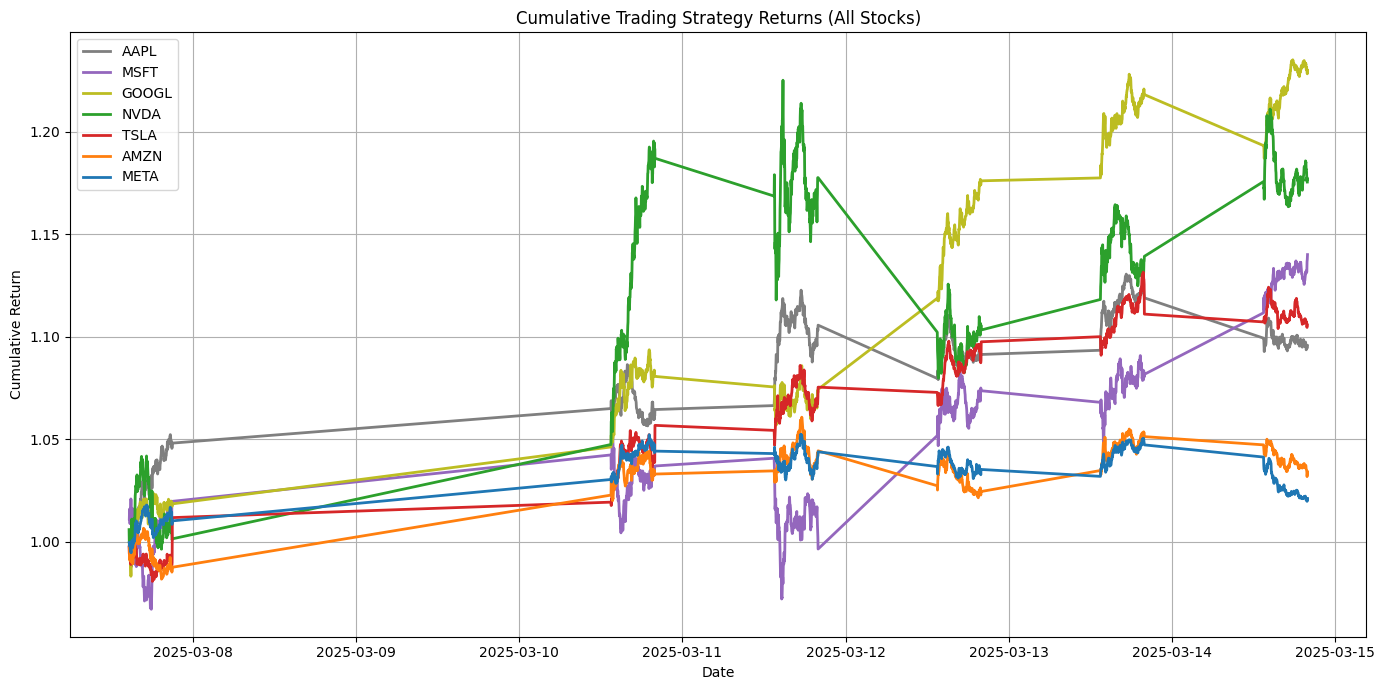

In [69]:
# Add rolling metrics
all_trades_df['Rolling_Risk'] = all_trades_df.groupby('Ticker')['Actual_Return'].transform(lambda x: x.rolling(window=10).std())
all_trades_df['Rolling_Average'] = all_trades_df.groupby('Ticker')['Actual_Return'].transform(lambda x: x.rolling(window=10).mean())

# Improved Trading Strategy Plot with consistent x-axis and grid
def plot_trading_strategy(all_trades_df):
    plt.figure(figsize=(14, 7))
    for ticker, color in zip(stocks, colors):
        ticker_data = all_trades_df[all_trades_df['Ticker'] == ticker]
        plt.plot(pd.to_datetime(ticker_data['Date']), ticker_data['Cumulative_Return'], label=ticker, color=color, linewidth=2)
    plt.title('Cumulative Trading Strategy Returns (All Stocks)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_trading_strategy(all_trades_df)

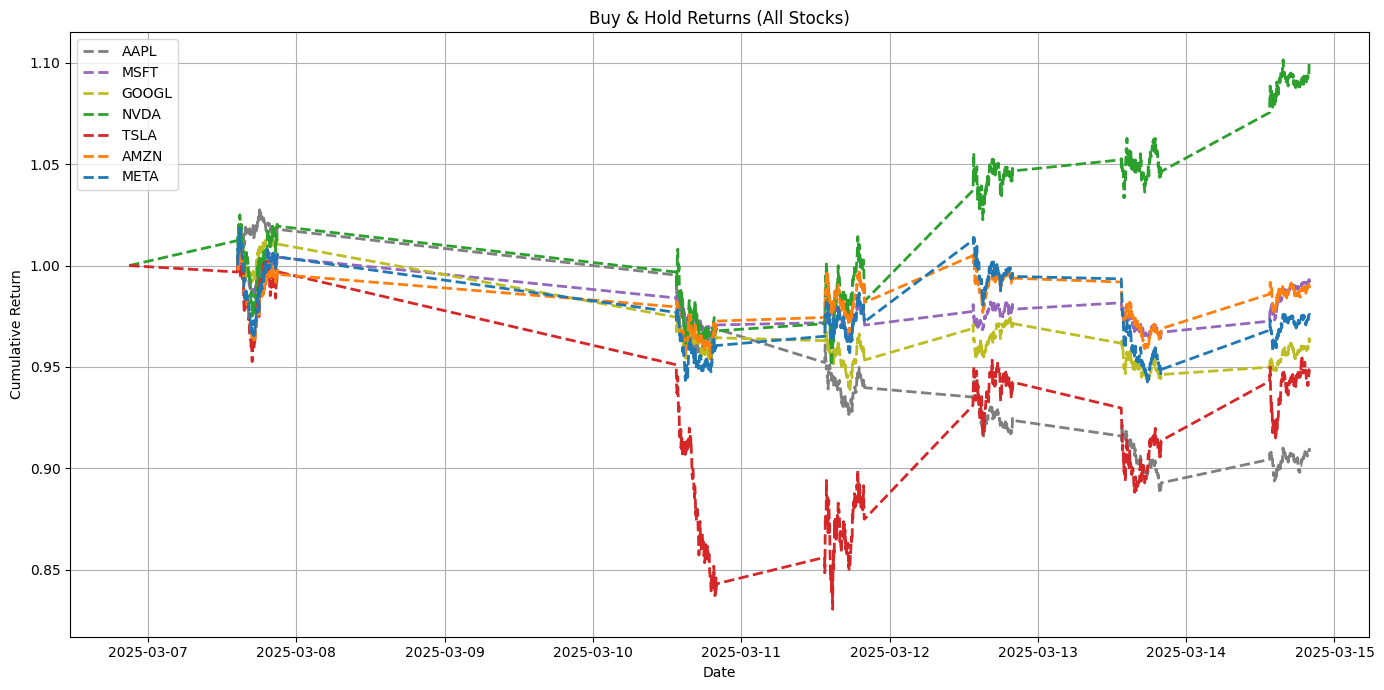

In [70]:
# Improved Buy & Hold Plot with consistent datetime parsing
def plot_buy_and_hold_test_period(df):
    plt.figure(figsize=(14, 7))
    for ticker, color in zip(stocks, colors):
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')
        split_idx = int(len(df_ticker) * 0.8)
        df_test = df_ticker.iloc[split_idx:]
        buy_hold_returns = df_test['Close'] / df_test['Close'].iloc[0]
        plt.plot(df_test['Datetime'], buy_hold_returns, label=f'{ticker}', color=color, linestyle='--', linewidth=2)
    plt.title('Buy & Hold Returns (All Stocks)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_buy_and_hold_test_period(df)

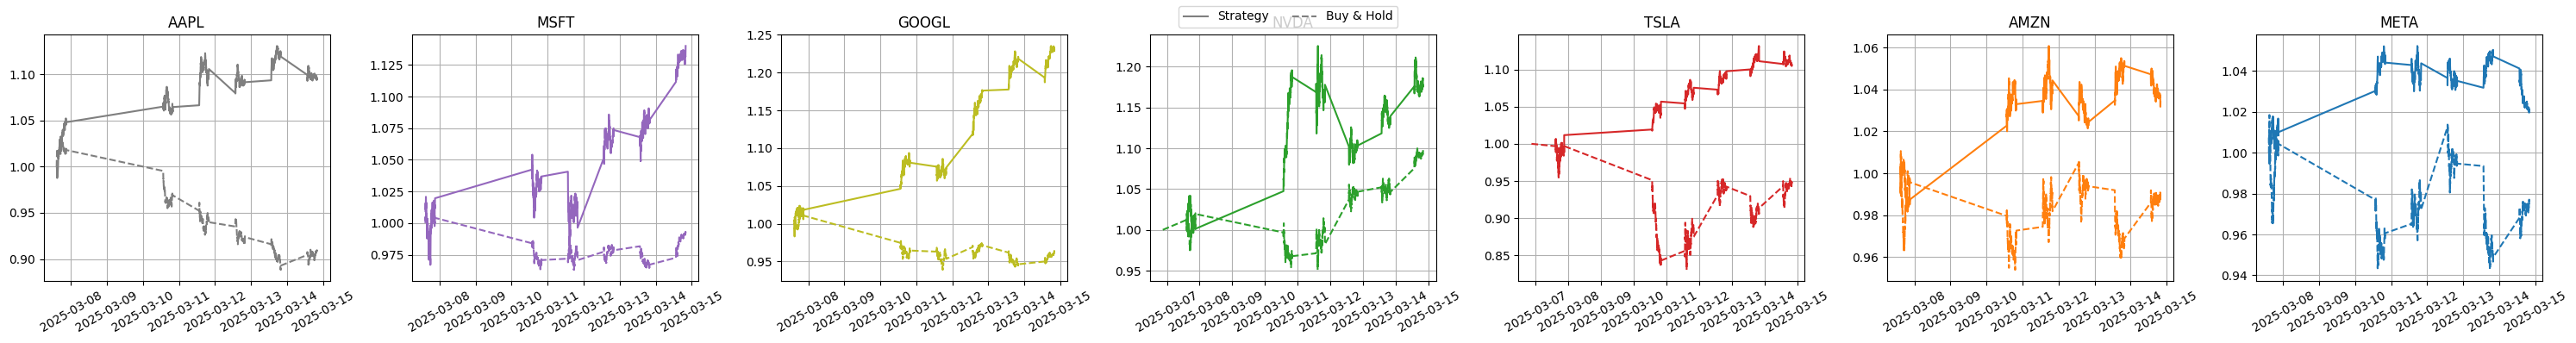

In [71]:
def plot_trading_vs_buy_hold(df, all_trades_df):
    fig, axes = plt.subplots(1, 7, figsize=(30, 4))
    for ax, ticker, color in zip(axes, stocks, colors):
        trades = all_trades_df[all_trades_df['Ticker'] == ticker]
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')
        split_idx = int(len(df_ticker) * 0.8)
        df_test = df_ticker.iloc[split_idx:]

        buy_hold_returns = df_test['Close'] / df_test['Close'].iloc[0]

        ax.plot(pd.to_datetime(trades['Date']), trades['Cumulative_Return'], color=color, label='Strategy')
        ax.plot(pd.to_datetime(df_test['Datetime']), buy_hold_returns, color=color, linestyle='--', label='Buy & Hold')

        ax.set_title(f'{ticker}')
        ax.grid(True)
        ax.tick_params(axis='x', rotation=30)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, frameon=True, fontsize=10)
    plt.tight_layout()
    plt.show()

plot_trading_vs_buy_hold(df, all_trades_df)

In [72]:
# Compare final returns
def calculate_strategy_returns(df, all_trades_df):
    results = []
    for ticker in df['Ticker'].unique():
        df_ticker = df[df['Ticker'] == ticker].sort_values('Datetime')
        split_index = int(len(df_ticker) * 0.8)
        df_test = df_ticker.iloc[split_index:]

        buy_and_hold_return = (df_test['Close'].iloc[-1] / df_test['Close'].iloc[0]) - 1

        df_trades = all_trades_df[all_trades_df['Ticker'] == ticker]
        strategy_return = df_trades['Cumulative_Return'].iloc[-1] - 1 if not df_trades.empty else None

        results.append({
            "Ticker": ticker,
            "Buy & Hold Return (%)": round(buy_and_hold_return * 100, 2),
            "Trading Strategy Return (%)": round(strategy_return * 100, 2) if strategy_return is not None else None
        })
    return pd.DataFrame(results)

strategy_returns_df = calculate_strategy_returns(df, all_trades_df)
print(strategy_returns_df)

  Ticker  Buy & Hold Return (%)  Trading Strategy Return (%)
0   AAPL                  -9.15                         9.56
1   AMZN                  -1.10                         3.40
2  GOOGL                  -3.81                        22.99
3   META                  -2.43                         2.10
4   MSFT                  -0.82                        14.01
5   NVDA                  10.06                        17.55
6   TSLA                  -5.09                        10.58


In [73]:
all_trades_df.head(5)

Date  Close_Price  Actual_Return  Predicted_Return Position  \
0 2025-03-07 14:38:00   237.309998       0.000901         -0.000122    SHORT   
1 2025-03-07 14:40:00   238.070007       0.001375         -0.000107    SHORT   
2 2025-03-07 14:42:00   238.220001       0.001973         -0.000080    SHORT   
3 2025-03-07 14:44:00   238.304993      -0.001146         -0.000095    SHORT   
4 2025-03-07 14:46:00   238.300003      -0.000100         -0.000107    SHORT   

   Cumulative_Return Ticker  Rolling_Risk  Rolling_Average  
0           0.999099   AAPL           NaN              NaN  
1           0.997725   AAPL           NaN              NaN  
2           0.995756   AAPL           NaN              NaN  
3           0.996898   AAPL           NaN              NaN  
4           0.996997   AAPL           NaN              NaN

In [74]:
all_trades_df.tail(5)

Date  Close_Price  Actual_Return  Predicted_Return  \
8156 2025-03-14 19:50:00   606.769775      -0.000385         -0.000010   
8157 2025-03-14 19:52:00   607.244995      -0.000077         -0.000010   
8158 2025-03-14 19:54:00   607.989990       0.001256         -0.000013   
8159 2025-03-14 19:56:00   608.359985      -0.000188         -0.000011   
8160 2025-03-14 19:58:00   607.570007      -0.001170         -0.000010   

     Position  Cumulative_Return Ticker  Rolling_Risk  Rolling_Average  
8156    SHORT           1.020833   META      0.000556         0.000103  
8157    SHORT           1.020912   META      0.000559         0.000081  
8158    SHORT           1.019629   META      0.000665         0.000216  
8159    SHORT           1.019821   META      0.000665         0.000142  
8160    SHORT           1.021014   META      0.000715         0.000115

In [75]:
all_trades_df.to_csv("returns.csv")